In [11]:
#Project for Quantitative Criticism Lab (UT Austin)
#Elias Sanchez
#DATASET USED : WORLD ATLAS OF LANGUAGE STRUCTURE (WALS) (WEBSITE: http://wals.info/)

import pandas as pd
import numpy as np
import csv
import math as m
import matplotlib.pyplot as plt

In [12]:
# Converts WALS coordinate data n to nearest n.25 or n.75 in order to search for classification
def rco(num):
    n = num-int(num)
    if n<=0.5:
        return (int(num)+ 0.25)
    else:
        return(int(num)+0.75)

In [13]:
#Auxilary binary search function
def binary(alist, item):
    if len(alist) == 0:
        return (-1)
    else:
        midpoint = len(alist)//2
        if alist[midpoint]==item:
          return (midpoint)
        else:
          if item<alist[midpoint]:
            return binary(alist[:midpoint],item)
          else:
            return binary(alist[midpoint+1:],item)

In [14]:
lang_df = pd.read_csv('language.csv', encoding = 'ISO-8859-1')

In [15]:
#koppen_1901-2010.tsv contains a file with latitude and longitudes that are close to .25 and .75 that gives the climate
koppen = np.genfromtxt("koppen_1901-2010.tsv", dtype=None, names=True)

In [16]:
#Translate longitude and latitude to Climate use binary search to look for num. coordinates
Clim = []
for i in range(0, len(lang_df)):
    s = 0
    if rco(lang_df['longitude'][i]) == -179.75:
        s = 0
    else:
        #binary search in first columns
        long = rco(lang_df['longitude'][i]) - 0.5
        s = binary(koppen['longitude'],long)
    
    if s==-1:
            Clim.append(str("NaN"))
            print(i)
    else:
        j=s
        lat = rco(lang_df['latitude'][i])
        lon = rco(lang_df['longitude'][i])
        
        while bool(lat == koppen['latitude'][j] and lon== koppen['longitude'][j])==False and bool(koppen['longitude'][j]< lon+1)==True:
            j=j+1
            if j== len(koppen['latitude'])-1:
                break
        
        if rco(lang_df['latitude'][i])== koppen['latitude'][j] and rco(lang_df['longitude'][i])==koppen['longitude'][j]:
            Clim.append(str(koppen['p1901_2010'][j]))
        else:
            Clim.append("NaN")
                                                                       
        

In [23]:
k = np.asarray(Clim)
k = k.tolist()

#get first letter of Koppen classification
for i in range(0, len(k)):
    if k[i]!='NaN':
        k[i] = k[i][2]

lang_df["Climate"] = k
# drop languages that where unale to be classified with Koppen
lang_df = lang_df[lang_df.Climate != 'NaN']



In [262]:
phon_df = lang_df[lang_df['4A Voicing in Plosives and Fricatives'].notnull() & lang_df['5A Voicing and Gaps in Plosive Systems'].notnull() & 
                  lang_df['6A Uvular Consonants'].notnull() & lang_df['7A Glottalized Consonants'].notnull() & 
                  lang_df['8A Lateral Consonants'].notnull() & lang_df['11A Front Rounded Vowels'].notnull() & 
                  lang_df['13A Tone'].notnull() & lang_df['18A Absence of Common Consonants'].notnull() & 
                  lang_df['19A Presence of Uncommon Consonants'].notnull() & lang_df['12A Syllable Structure'].notnull()]

phon_feat = ['4A Voicing in Plosives and Fricatives', '5A Voicing and Gaps in Plosive Systems', '6A Uvular Consonants', '7A Glottalized Consonants',
                '8A Lateral Consonants', '11A Front Rounded Vowels', '13A Tone', '18A Absence of Common Consonants', '19A Presence of Uncommon Consonants', '12A Syllable Structure']

#clphon = pd.Series.tolist(phon_df['Climate'])
#stats_out(clphon)

In [270]:
#Dummy classifier
def dummy_clas(clasdum, x, y):
    clasdum.fit(x,y)
    scores = []
    for i in range(0,500):
        scores.append(clasdum.score( x, y))
    scoresnp = np.array(scores)
    score = np.average(scoresnp)
    return(score)

In [271]:
#Pre-proccessing - OHE for both y input and output vectors
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
enc = OneHotEncoder()
x_phon, y_phon = df_list(phon_feat, phon_df)
enc = OneHotEncoder()
x_phon = enc.fit_transform(x_phon).toarray()
lb.fit(y_phon)
y_phon = lb.transform(y_phon)

#run SVC - One-vs.-rest
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier


def sv_and_dummy(inp,pred):
    
    sv_ovr = OneVsRestClassifier(LinearSVC(random_state=0, class_weight='balanced'))
    
    svmm = OneVsRestClassifier(SVC(kernel= "linear", class_weight='balanced'))
    dummyclas = DummyClassifier()
    
    scores_1 = cross_val_score(sv_ovr, inp, pred, cv=5)
    scores_2 = cross_val_score(svmm, inp, pred, cv=5)
    print("C-V scores, SV Method 1  - OHE : ")
    print(scores_1)
    print("C-V scores, SV Method 1  - non-OHE : ")
    print(scores_2)
    print("C-V scores, Dummy Classifier:")

    print(dummy_clas(dummyclas, inp, lb.inverse_transform(pred)))
    #95 percent Confidence Interval
    print("Accuracy for C-V (95 CI) , Method 1  - OHE : %0.2f (+/- %0.2f)" % (scores_1.mean(), scores_1.std() * 2))
    print("Accuracy for C-V (95 CI), Method 2  - OHE : %0.2f (+/- %0.2f)" % (scores_2.mean(), scores_2.std() * 2))
    
sv_and_dummy(x_phon, y_phon)

C-V scores, SV Method 1  - OHE : 
[ 0.24390244  0.35365854  0.2345679   0.25925926  0.24691358]
C-V scores, SV Method 1  - non-OHE : 
[ 0.23170732  0.34146341  0.27160494  0.20987654  0.2345679 ]
C-V scores, Dummy Classifier:
0.294014742015
Accuracy for C-V (95 CI) , Method 1  - OHE : 0.27 (+/- 0.09)
Accuracy for C-V (95 CI), Method 2  - OHE : 0.26 (+/- 0.09)


In [28]:
#Basic Ststistic for Output vector function Distribution of Climate languages for WALS data set (General)
def stats_out(Y):
    A=0
    B=0
    C=0
    D=0
    E=0
    for i in range(0,len(Y)):
        if Y[i] == 'A':
            A+=1
        elif Y[i] == 'B':
            B+=1
        elif Y[i] == 'C':
            C+=1
        elif Y[i] == 'D':
            D+=1
        elif Y[i] == 'E':
            E+=1
    print("A - Tropical: " + str(A) )
    print("B - Arid: " + str(B) )
    print("C - Temperate: " + str(C) )
    print("D - Cold: " + str(D) )
    print("E - Polar: " + str(E) )

#Distribution of Climate languages for WALS data set (General)

Cl= pd.Series.tolist(lang_df['Climate'])
stats_out(Cl)
print(len(Cl))


    

A - Tropical: 1036
B - Arid: 344
C - Temperate: 553
D - Cold: 234
E - Polar: 68
2235


In [30]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    imp = coef
    
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()


In [31]:
#Pandas DF and Features to X-feature list and Y-vector (Climate)

def df_list(features, df):
    l = []
    for i in range(0, len(features)):
        l.append(pd.Series.tolist(pd.to_numeric(df[features[i]].str[0])))
    
    x = []
    
    for i in range(0,len(l[0])):
        x.append([])
        
    for i in range(0,len(l[0])):
        for k in range(0,len(features)):
            x[i].append(l[k][i])
    Y = pd.Series.tolist(df['Climate'])
    
    return (x,Y)
    

In [133]:
#confusion matrix for SVC for One vs Rest Classifier
sv_ovr = OneVsRestClassifier(LinearSVC(random_state=0, class_weight='balanced'))
sv_ovr.fit(x_phon, y_phon)
pred = sv_ovr.predict(x_phon)
yn_phon = lb.inverse_transform(y_phon)
pred = lb.inverse_transform(pred)
y_actu = pd.Series(yn_phon, name='Actual')
y_pred = pd.Series(pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,A,B,C,D,E
Actual,,,,,
A,143,19,13,1,0
B,22,41,7,4,0
C,30,25,42,3,0
D,5,10,17,13,0
E,0,4,4,3,1


In [33]:
#Normalized confusion matrix
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_conf_norm

Predicted,A,B,C,D,E
Actual,,,,,
A,0.812500,0.256757,0.13,0.022222,0.000000
B,0.125000,0.554054,0.07,0.088889,0.000000
C,0.170455,0.337838,0.42,0.066667,0.000000
D,0.028409,0.135135,0.17,0.288889,0.000000
E,0.000000,0.054054,0.04,0.066667,0.083333


In [34]:
#Simple accuracy measurement
c=0
for i in range(0, len(pred)):
    if pred[i]== yn_phon[i]:
        c=c+1
c/len(pred)


0.5896805896805897

In [35]:
#OHE feature importance correction auxilary function (combines all the features)

def feat_imp_ohe(ft_ind, act_ft, coef):
    ft = []
    final =[]
    for i in range(0, len(ft_ind)-1):
        ft.append([])
    for j in range(0, len(act_ft)):
        for k in range (0, len(ft_ind)-1):
            if act_ft[j] >= ft_ind[k] and act_ft[j]<= ft_ind[k+1]-1:
                ft[k].append(act_ft[j])
                
    for l in range(0, len(ft)):
        lis = []
        for m in range(0, len(ft[l])):
            lis.append(coef[0])
            coef.pop(0)
        final.append(sum(lis))
    
    return(final)
            
        


Coefficients for One vs Rest SVM:

 Feature ranking:
47
[8 3 1 7 5 2 4 9 6 0]
['4A Voicing in Plosives and Fricatives', '5A Voicing and Gaps in Plosive Systems', '6A Uvular Consonants', '7A Glottalized Consonants', '8A Lateral Consonants', '11A Front Rounded Vowels', '13A Tone', '18A Absence of Common Consonants', '19A Presence of Uncommon Consonants', '12A Syllable Structure']
[0.020672409010509228, 0.13771878088872044, 0.06620502412367382, 0.15596366767446274, 0.05820690573317397, 0.08853245106122866, 0.04115386626822309, 0.11235464008197388, 0.27743257848538944, 0.04175967667264476]
1. feature 9 - 19A Presence of Uncommon Consonants (0.277433)
2. feature 4 - 7A Glottalized Consonants (0.155964)
3. feature 2 - 5A Voicing and Gaps in Plosive Systems (0.137719)
4. feature 8 - 18A Absence of Common Consonants (0.112355)
5. feature 6 - 11A Front Rounded Vowels (0.088532)
6. feature 3 - 6A Uvular Consonants (0.066205)
7. feature 5 - 8A Lateral Consonants (0.058207)
8. feature 10 - 12A Syl

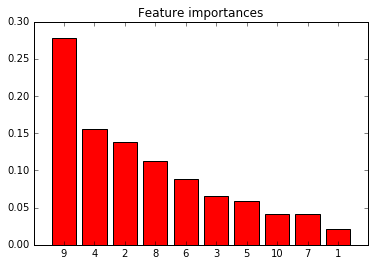

In [158]:
#Feature Importance - for each list j, represents the jth feature vs Rest linear SVM's coefficient

sv_ovr.fit(x_phon, y_phon)
coef = sv_ovr.coef_


print("Coefficients for One vs Rest SVM:")

a = np.absolute(coef)
b = np.sum(a, axis=0)
b = np.square(b)
s = sum(b)
feat = np.true_divide(b,s)
feat = np.asarray(feat)
feat = feat.tolist()

feat = feat_imp_ohe(enc.feature_indices_, enc.active_features_, feat)

ind = np.argsort(feat)[::-1]

print("\n Feature ranking:")

X = np.asarray(x_phon)
print(X.shape[1])
print(ind)
print(phon_feat)
print(feat)
for f in range(len(feat)):
    print("%d. feature %d - %s (%f)" % (f + 1, ind[f] + 1, phon_feat[ind[f]], feat[ind[f]]))
    
feat = np.asarray(feat)
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(feat)), feat[ind],
       color="r", align="center")
plt.xticks(range(len(feat)), ind+1)
plt.xlim([-1, len(feat)])
plt.show()






In [37]:
#Random Forest Multi-Classification with One Hot Encoding for Climate Vector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import permutation_test_score
from sklearn.cross_validation import StratifiedKFold


In [38]:
train_x, test_x, train_y, test_y = train_test_split(x_phon, y_phon)

In [39]:
rfc = RandomForestClassifier()
rfc.fit(x_phon, y_phon)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
trained_model = rfc.fit(train_x, train_y)
trained_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
predictions = trained_model.predict(test_x)
test_y = lb.inverse_transform(test_y)
predictions = lb.inverse_transform(predictions)
print("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print("Test Accuracy  :: ", accuracy_score(test_y, predictions))

Train Accuracy ::  0.796721311475
Test Accuracy  ::  0.578431372549


In [42]:
#Cross validation for RF 95% Confidence Interval
scores = cross_val_score(rfc, x_phon, y_phon, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.41463415  0.5         0.27160494  0.40740741  0.39506173]
Accuracy: 0.40 (+/- 0.15)


In [43]:
#Confusion matrix for tested sample
#predictions = lb.inverse_transform(predictions)
y_actu = pd.Series(test_y, name='Actual')
y_pred = pd.Series(predictions, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,A,B,C,D
Actual,,,,
A,43,4,4,1
B,6,10,1,0
C,14,4,6,3
D,4,1,0,0
E,1,0,0,0


Feature ranking:
1. feature 4 - 7A Glottalized Consonants (0.150987)
2. feature 9 - 19A Presence of Uncommon Consonants (0.125714)
3. feature 2 - 5A Voicing and Gaps in Plosive Systems (0.108278)
4. feature 3 - 6A Uvular Consonants (0.106637)
5. feature 1 - 4A Voicing in Plosives and Fricatives (0.106565)
6. feature 5 - 8A Lateral Consonants (0.101428)
7. feature 7 - 13A Tone (0.100348)
8. feature 10 - 12A Syllable Structure (0.097283)
9. feature 8 - 18A Absence of Common Consonants (0.052390)
10. feature 6 - 11A Front Rounded Vowels (0.050369)


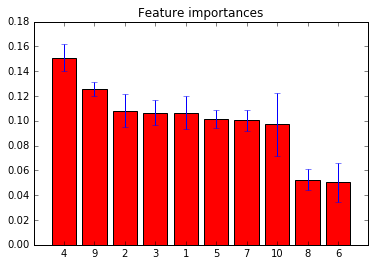

In [44]:
#Feature Importance
importances = trained_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in trained_model.estimators_],
             axis=0)

importances = importances.tolist()

# Print the feature ranking
print("Feature ranking:")

X = np.asarray(x_phon)


importances = feat_imp_ohe(enc.feature_indices_, enc.active_features_, importances)

indices = np.argsort(importances)[::-1]

for f in range(0,len(importances)):
    print("%d. feature %d - %s (%f)" % ( f + 1 , indices[f] + 1, phon_feat[indices[f]], importances[indices[f]]))
    
importances = np.asarray(importances)
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(importances)), (indices+1))
plt.xlim([-1, len(importances)])
plt.show()



Extra Tree Classifier:

[ 0.3902439   0.53658537  0.2962963   0.34567901  0.41975309] 

Accuracy: 0.40 (+/- 0.16)

Feature ranking:
1. feature 4 - 7A Glottalized Consonants (0.157845)
2. feature 9 - 19A Presence of Uncommon Consonants (0.144616)
3. feature 1 - 4A Voicing in Plosives and Fricatives (0.117147)
4. feature 3 - 6A Uvular Consonants (0.111093)
5. feature 5 - 8A Lateral Consonants (0.104132)
6. feature 2 - 5A Voicing and Gaps in Plosive Systems (0.101834)
7. feature 10 - 12A Syllable Structure (0.093091)
8. feature 7 - 13A Tone (0.089429)
9. feature 6 - 11A Front Rounded Vowels (0.042928)
10. feature 8 - 18A Absence of Common Consonants (0.037885)


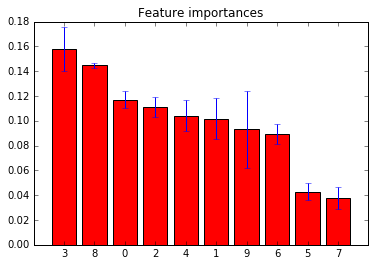

In [45]:
#Extra Tree Classifier
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(random_state=0)

forest.fit(x_phon, y_phon)
etcv = cross_val_score(forest, x_phon, y_phon, cv=5)
print("Extra Tree Classifier:\n")

print(etcv,"\n")

print("Accuracy: %0.2f (+/- %0.2f)\n" % (etcv.mean(), etcv.std() * 2))

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

importances = importances.tolist()
importances = feat_imp_ohe(enc.feature_indices_, enc.active_features_, importances)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(len(importances)):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f]+1, phon_feat[indices[f]], importances[indices[f]]))

importances = np.asarray(importances)
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(importances)), indices)
plt.xlim([-1, len(importances)])
plt.show()


In [328]:
# Aux Function Linear SVM Feature Importance for binary classification OHE
def svm_feat_imp(clas, xi, yi, feat_names):
    
    global imp
    
    clas.fit(xi,yi)
    feat_c = clas.coef_[0]
    
    feat_c = np.asarray(feat_c)
    
    feat_c = np.absolute(feat_c)
    
    feat_c = feat_c.tolist()
    feat_c = feat_imp_ohe(enco.feature_indices_, enco.active_features_, feat_c)

    ind = np.argsort(feat_c)[::-1]
    
    top = (indices.tolist())[0:3]
    indx = indices.tolist()
    
    for i in range(0, len(indx)):
        if (indx[i] in top == True):
            imp[i] += 1
        
    print("Feature ranking:")
    
    
    for f in range(len(feat_c)):
        print("%d. feature %d - %s (%f)" % (f + 1, ind[f], feat_names[ind[f]], feat_c[ind[f]]))
    feat_c = np.asarray(feat_c)

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(feat_c)), feat_c[ind], color="r", align="center")
    plt.xticks(range(len(feat_c)), ind+1)
    plt.xlim([-1, len(feat_c)])
    plt.show()
    
    
#RF Feature Importance for binary classification Function with OHE
def RFC_feat_imp(efc, feat, inp_x, inp_y):
    
    global imp
    
    trained_model = rfc.fit(inp_x, inp_y)
    
    importances = trained_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in trained_model.estimators_],axis=0)
    
    importances = importances.tolist()
    
    importances = feat_imp_ohe(enco.feature_indices_, enco.active_features_, importances)
    
    indices = np.argsort(importances)[::-1]
    
    
    top = (indices.tolist())[0:3]
    ind = indices.tolist()
    
    for i in range(0, len(ind)):
        if (ind[i] in top == True):
            imp[i] += 1
    
    # Print the feature ranking
    print("Feature ranking:")


    for f in range(len(feat)):
        print("%d. feature %d - %s (%f)" % (f+1, indices[f], feat[indices[f]], importances[indices[f]]))
    
    importances = np.asarray(importances)

    
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(feat)), importances[indices],color="r", yerr=std[indices], align="center")
    plt.xticks(range(len(feat)), indices)
    plt.xlim([-1, len(feat)])
    plt.show()
    

    
    

In [47]:
subsets = [['A','B'],['A','C'],['A','D'],['A','E'],['B','C'],['B','D'],['B','E'],['C','D'],['C','E'],['D','E']]

In [291]:
#Phonological - Binary Classifications

def Clim_let(lst):
    
    dic ={'A':'TROPICAL','B':'ARID', 'C':'TEMPERATE', 'D': 'COLD', 'E':'POLAR'}
    print(dic.get(lst[0]) + " AND " + dic.get(lst[1]) + " - BINARY CLASSIFICATION")
    
    

#Function that makes binary classification between each individual class for RF and linear SVM with CV and Feature importance for each


#Get each individual sample from the data set and put it into lists
def binary_clas(df, ft, clim_subs):
    global imp
    imp =[]
    for i in range(0,10):
        imp.append(0)
    
    
    x_lst = []
    y_lst = []
    
    for i in range(0, len(clim_subs)):
        x = []
        y = []
        b_df =  df[(df['Climate'] == str(clim_subs[i][0])) | (df['Climate'] == str(clim_subs[i][1]))]
        x,y = df_list(ft, b_df)
        x_lst.append(x)
        y_lst.append(y)
    
    #Initialize classifiers
    rf = RandomForestClassifier(class_weight = 'balanced')
    sv = svm.SVC(kernel= "linear", class_weight = 'balanced')
    et = ExtraTreesClassifier(random_state=0, class_weight = 'balanced')

    for j in range(0,len(y_lst)):
        
        Clim_let(clim_subs[j])
        trained_model = rf.fit(x_lst[j],y_lst[j])
        cvsv = cross_val_score(sv, x_lst[j], y_lst[j], cv=4)
        
        t_m = et.fit(x_lst[j],y_lst[j])
        
        x_lst[j] = enc.fit_transform(x_lst[j]).toarray()
        
        print("Dummy Classifier Average Score:")
        dummyclas.fit(x_lst[j], y_lst[j])
        print(dummy_clas(dummyclas, x_lst[j], y_lst[j]))
        
        print("\n Linear SVM Classification C-V:")
        print("Accuracy: %0.2f (+/- %0.2f)" % (cvsv.mean(), cvsv.std() * 2))
        print("Linear SVM Feature Importance: \n")
        svm_feat_imp(sv, x_lst[j], y_lst[j], ft)
        
        cvrf = cross_val_score(rf, x_lst[j], y_lst[j], cv=5)
        print()
        print("\n Random Forest Classification C-V: \n")
        
        print("Accuracy: %0.2f (+/- %0.2f)" % (cvrf.mean(), cvrf.std() * 2))
        RFC_feat_imp(trained_model, ft, x_lst[j], y_lst[j])
        print()
        
        print("Extra Trees Classification: \n")
        
        etcv = cross_val_score(et, x_lst[j], y_lst[j], cv=5)
        print(etcv)
        print("Accuracy: %0.2f (+/- %0.2f)\n" % (etcv.mean(), etcv.std() * 2))
        RFC_feat_imp(t_m, ft, x_lst[j], y_lst[j])
        print()
        
        print("PERMUTATION TEST: \n")
        
        
        x = np.asarray(x_lst[j])
        y = np.asarray(y_lst[j])
        score_svm, permutation_scores, pvalue_svm = permutation_test_score(sv, x, y, cv = 4, n_permutations=100, n_jobs=1)
        print("Linear SVM - Classification score %s (pvalue : %s )\n" % (score_svm, pvalue_svm))
        
        score_rf, permutation_scores, pvalue_rf = permutation_test_score(rf, x, y, scoring="accuracy", cv=4, n_permutations=100, n_jobs=1)
        
        print("Random Forest - Classification score %s (pvalue : %s)\n" % (score_rf, pvalue_rf))
        
    print(imp)
        
        
        
        
    
    

TROPICAL AND ARID - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.580856

 Linear SVM Classification C-V:
Accuracy: 0.60 (+/- 0.07)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 8 - 19A Presence of Uncommon Consonants (4.619583)
2. feature 1 - 5A Voicing and Gaps in Plosive Systems (3.845821)
3. feature 4 - 8A Lateral Consonants (3.460681)
4. feature 3 - 7A Glottalized Consonants (2.585537)
5. feature 9 - 12A Syllable Structure (2.039579)
6. feature 5 - 11A Front Rounded Vowels (1.266427)
7. feature 2 - 6A Uvular Consonants (0.571185)
8. feature 6 - 13A Tone (0.385992)
9. feature 7 - 18A Absence of Common Consonants (0.319721)
10. feature 0 - 4A Voicing in Plosives and Fricatives (0.295311)


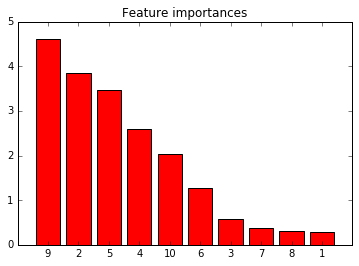



 Random Forest Classification C-V: 

Accuracy: 0.75 (+/- 0.10)
Feature ranking:
1. feature 8 - 19A Presence of Uncommon Consonants (0.211225)
2. feature 3 - 7A Glottalized Consonants (0.138218)
3. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.121330)
4. feature 9 - 12A Syllable Structure (0.115603)
5. feature 2 - 6A Uvular Consonants (0.106406)
6. feature 4 - 8A Lateral Consonants (0.093104)
7. feature 6 - 13A Tone (0.091060)
8. feature 0 - 4A Voicing in Plosives and Fricatives (0.087804)
9. feature 7 - 18A Absence of Common Consonants (0.023009)
10. feature 5 - 11A Front Rounded Vowels (0.012241)


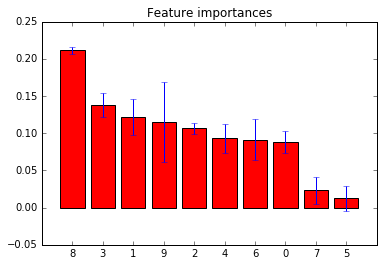


Extra Trees Classification: 

[ 0.82352941  0.72        0.7         0.76        0.7755102 ]
Accuracy: 0.76 (+/- 0.09)

Feature ranking:
1. feature 8 - 19A Presence of Uncommon Consonants (0.185851)
2. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.146463)
3. feature 0 - 4A Voicing in Plosives and Fricatives (0.123433)
4. feature 3 - 7A Glottalized Consonants (0.108254)
5. feature 4 - 8A Lateral Consonants (0.103545)
6. feature 6 - 13A Tone (0.094855)
7. feature 9 - 12A Syllable Structure (0.094443)
8. feature 2 - 6A Uvular Consonants (0.089890)
9. feature 7 - 18A Absence of Common Consonants (0.034976)
10. feature 5 - 11A Front Rounded Vowels (0.018290)


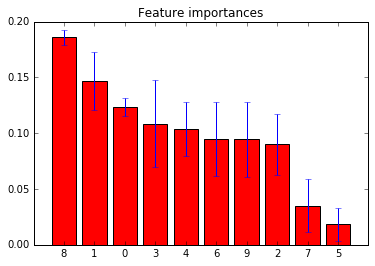


PERMUTATION TEST: 

Linear SVM - Classification score 0.696108550947 (pvalue : 0.00990099009901 )

Random Forest - Classification score 0.759856630824 (pvalue : 0.00990099009901)

TROPICAL AND TEMPERATE - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.537434782609

 Linear SVM Classification C-V:
Accuracy: 0.68 (+/- 0.10)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 3 - 7A Glottalized Consonants (4.064849)
2. feature 4 - 8A Lateral Consonants (3.797907)
3. feature 1 - 5A Voicing and Gaps in Plosive Systems (3.683665)
4. feature 8 - 19A Presence of Uncommon Consonants (3.123629)
5. feature 2 - 6A Uvular Consonants (2.488518)
6. feature 7 - 18A Absence of Common Consonants (2.400978)
7. feature 0 - 4A Voicing in Plosives and Fricatives (0.787299)
8. feature 9 - 12A Syllable Structure (0.267470)
9. feature 6 - 13A Tone (0.265409)
10. feature 5 - 11A Front Rounded Vowels (0.129382)


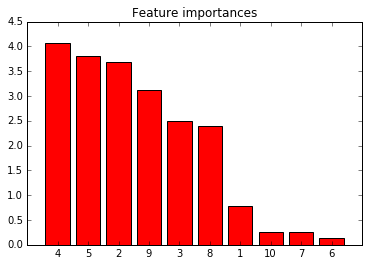



 Random Forest Classification C-V: 

Accuracy: 0.73 (+/- 0.16)
Feature ranking:
1. feature 3 - 7A Glottalized Consonants (0.158160)
2. feature 2 - 6A Uvular Consonants (0.134066)
3. feature 4 - 8A Lateral Consonants (0.126760)
4. feature 0 - 4A Voicing in Plosives and Fricatives (0.107834)
5. feature 9 - 12A Syllable Structure (0.102598)
6. feature 8 - 19A Presence of Uncommon Consonants (0.095598)
7. feature 6 - 13A Tone (0.093150)
8. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.091747)
9. feature 7 - 18A Absence of Common Consonants (0.068438)
10. feature 5 - 11A Front Rounded Vowels (0.021650)


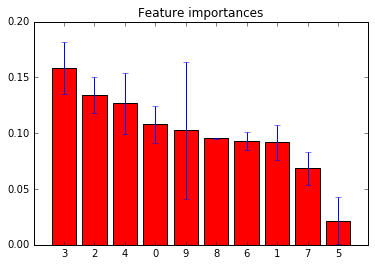


Extra Trees Classification: 

[ 0.69642857  0.83636364  0.65454545  0.65454545  0.69090909]
Accuracy: 0.71 (+/- 0.13)

Feature ranking:
1. feature 6 - 13A Tone (0.155972)
2. feature 3 - 7A Glottalized Consonants (0.129548)
3. feature 2 - 6A Uvular Consonants (0.125248)
4. feature 0 - 4A Voicing in Plosives and Fricatives (0.116853)
5. feature 8 - 19A Presence of Uncommon Consonants (0.116494)
6. feature 4 - 8A Lateral Consonants (0.099274)
7. feature 9 - 12A Syllable Structure (0.085356)
8. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.075716)
9. feature 7 - 18A Absence of Common Consonants (0.063697)
10. feature 5 - 11A Front Rounded Vowels (0.031841)


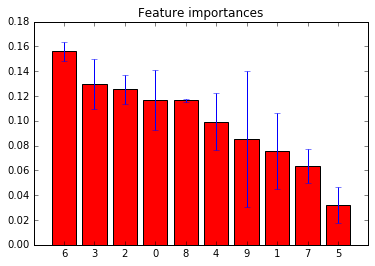


PERMUTATION TEST: 

Linear SVM - Classification score 0.692028985507 (pvalue : 0.00990099009901 )

Random Forest - Classification score 0.739130434783 (pvalue : 0.00990099009901)

TROPICAL AND COLD - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.678533936652

 Linear SVM Classification C-V:
Accuracy: 0.85 (+/- 0.04)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 3 - 7A Glottalized Consonants (3.095931)
2. feature 5 - 11A Front Rounded Vowels (2.819089)
3. feature 7 - 18A Absence of Common Consonants (2.404280)
4. feature 1 - 5A Voicing and Gaps in Plosive Systems (2.349758)
5. feature 4 - 8A Lateral Consonants (2.347209)
6. feature 9 - 12A Syllable Structure (2.221838)
7. feature 0 - 4A Voicing in Plosives and Fricatives (1.980369)
8. feature 6 - 13A Tone (1.599064)
9. feature 2 - 6A Uvular Consonants (1.558195)
10. feature 8 - 19A Presence of Uncommon Consonants (1.255682)


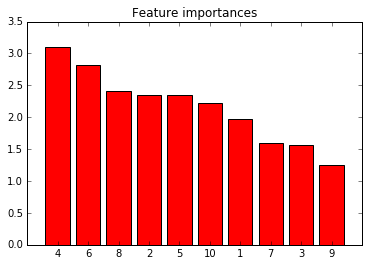



 Random Forest Classification C-V: 

Accuracy: 0.90 (+/- 0.08)
Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.336234)
2. feature 9 - 12A Syllable Structure (0.116740)
3. feature 0 - 4A Voicing in Plosives and Fricatives (0.094050)
4. feature 4 - 8A Lateral Consonants (0.089630)
5. feature 5 - 11A Front Rounded Vowels (0.085882)
6. feature 3 - 7A Glottalized Consonants (0.077817)
7. feature 6 - 13A Tone (0.067100)
8. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.052422)
9. feature 8 - 19A Presence of Uncommon Consonants (0.044200)
10. feature 7 - 18A Absence of Common Consonants (0.035926)


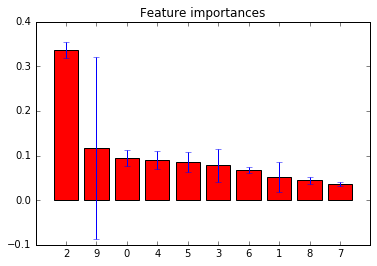


Extra Trees Classification: 

[ 0.93333333  0.90909091  0.86363636  0.90909091  0.84090909]
Accuracy: 0.89 (+/- 0.07)

Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.228282)
2. feature 0 - 4A Voicing in Plosives and Fricatives (0.150211)
3. feature 9 - 12A Syllable Structure (0.149221)
4. feature 5 - 11A Front Rounded Vowels (0.089054)
5. feature 6 - 13A Tone (0.079113)
6. feature 3 - 7A Glottalized Consonants (0.074907)
7. feature 4 - 8A Lateral Consonants (0.074543)
8. feature 8 - 19A Presence of Uncommon Consonants (0.064197)
9. feature 7 - 18A Absence of Common Consonants (0.051557)
10. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.038914)


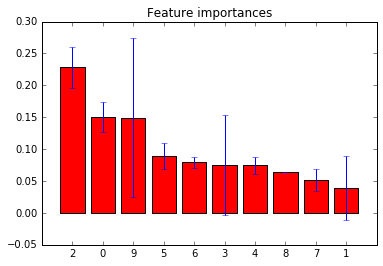


PERMUTATION TEST: 

Linear SVM - Classification score 0.896022727273 (pvalue : 0.00990099009901 )

Random Forest - Classification score 0.89586038961 (pvalue : 0.00990099009901)

TROPICAL AND POLAR - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.88020212766

 Linear SVM Classification C-V:
Accuracy: 0.91 (+/- 0.04)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 2 - 6A Uvular Consonants (2.667164)
2. feature 9 - 12A Syllable Structure (2.391464)
3. feature 0 - 4A Voicing in Plosives and Fricatives (2.358779)
4. feature 8 - 19A Presence of Uncommon Consonants (2.215348)
5. feature 5 - 11A Front Rounded Vowels (2.169599)
6. feature 4 - 8A Lateral Consonants (1.716814)
7. feature 3 - 7A Glottalized Consonants (1.706704)
8. feature 6 - 13A Tone (1.706704)
9. feature 1 - 5A Voicing and Gaps in Plosive Systems (1.657549)
10. feature 7 - 18A Absence of Common Consonants (0.779418)


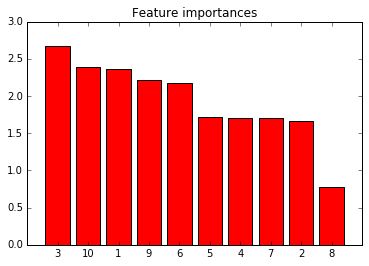



 Random Forest Classification C-V: 

Accuracy: 0.96 (+/- 0.06)
Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.333352)
2. feature 5 - 11A Front Rounded Vowels (0.195463)
3. feature 0 - 4A Voicing in Plosives and Fricatives (0.116863)
4. feature 8 - 19A Presence of Uncommon Consonants (0.084849)
5. feature 9 - 12A Syllable Structure (0.083002)
6. feature 4 - 8A Lateral Consonants (0.058512)
7. feature 3 - 7A Glottalized Consonants (0.040924)
8. feature 6 - 13A Tone (0.038459)
9. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.029916)
10. feature 7 - 18A Absence of Common Consonants (0.018659)


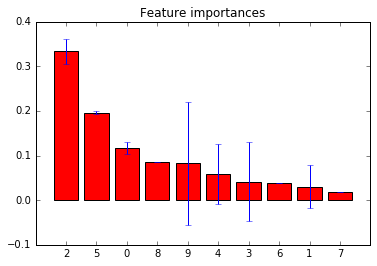


Extra Trees Classification: 

[ 0.97435897  0.94736842  0.91891892  0.97297297  1.        ]
Accuracy: 0.96 (+/- 0.06)

Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.351894)
2. feature 0 - 4A Voicing in Plosives and Fricatives (0.156208)
3. feature 5 - 11A Front Rounded Vowels (0.140488)
4. feature 4 - 8A Lateral Consonants (0.080855)
5. feature 6 - 13A Tone (0.073271)
6. feature 9 - 12A Syllable Structure (0.055958)
7. feature 8 - 19A Presence of Uncommon Consonants (0.050803)
8. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.038782)
9. feature 3 - 7A Glottalized Consonants (0.038521)
10. feature 7 - 18A Absence of Common Consonants (0.013219)


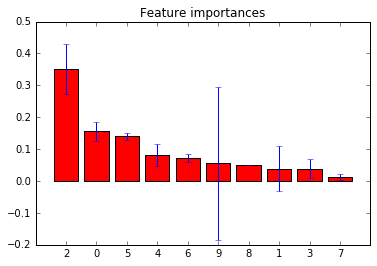


PERMUTATION TEST: 

Linear SVM - Classification score 0.952127659574 (pvalue : 0.00990099009901 )

Random Forest - Classification score 0.957446808511 (pvalue : 0.00990099009901)

ARID AND TEMPERATE - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.50783908046

 Linear SVM Classification C-V:
Accuracy: 0.61 (+/- 0.04)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 8 - 19A Presence of Uncommon Consonants (4.689938)
2. feature 3 - 7A Glottalized Consonants (3.384164)
3. feature 1 - 5A Voicing and Gaps in Plosive Systems (3.186335)
4. feature 7 - 18A Absence of Common Consonants (2.645996)
5. feature 5 - 11A Front Rounded Vowels (2.351351)
6. feature 4 - 8A Lateral Consonants (0.141821)
7. feature 0 - 4A Voicing in Plosives and Fricatives (0.125361)
8. feature 2 - 6A Uvular Consonants (0.108385)
9. feature 6 - 13A Tone (0.085091)
10. feature 9 - 12A Syllable Structure (0.043809)


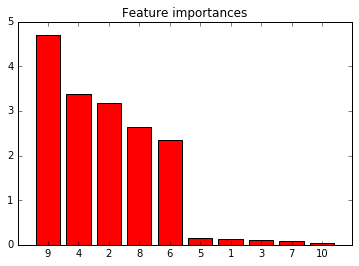



 Random Forest Classification C-V: 

Accuracy: 0.67 (+/- 0.09)
Feature ranking:
1. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.159208)
2. feature 3 - 7A Glottalized Consonants (0.149159)
3. feature 0 - 4A Voicing in Plosives and Fricatives (0.136102)
4. feature 6 - 13A Tone (0.114980)
5. feature 9 - 12A Syllable Structure (0.093099)
6. feature 8 - 19A Presence of Uncommon Consonants (0.088054)
7. feature 2 - 6A Uvular Consonants (0.088031)
8. feature 4 - 8A Lateral Consonants (0.082313)
9. feature 7 - 18A Absence of Common Consonants (0.063751)
10. feature 5 - 11A Front Rounded Vowels (0.025303)


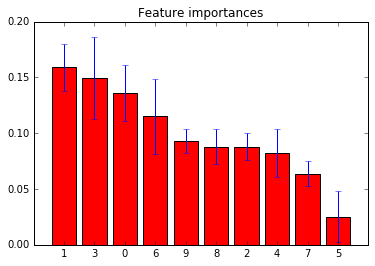


Extra Trees Classification: 

[ 0.65714286  0.74285714  0.62857143  0.65714286  0.67647059]
Accuracy: 0.67 (+/- 0.08)

Feature ranking:
1. feature 3 - 7A Glottalized Consonants (0.151923)
2. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.150316)
3. feature 0 - 4A Voicing in Plosives and Fricatives (0.107894)
4. feature 6 - 13A Tone (0.101944)
5. feature 8 - 19A Presence of Uncommon Consonants (0.099531)
6. feature 4 - 8A Lateral Consonants (0.097663)
7. feature 9 - 12A Syllable Structure (0.095904)
8. feature 2 - 6A Uvular Consonants (0.092806)
9. feature 7 - 18A Absence of Common Consonants (0.062541)
10. feature 5 - 11A Front Rounded Vowels (0.039478)


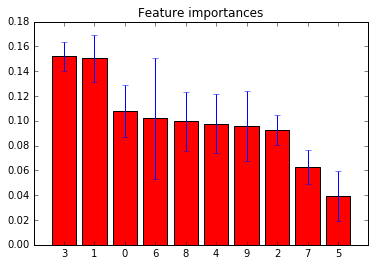


PERMUTATION TEST: 

Linear SVM - Classification score 0.729915433404 (pvalue : 0.00990099009901 )

Random Forest - Classification score 0.706527484144 (pvalue : 0.00990099009901)

ARID AND COLD - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.534

 Linear SVM Classification C-V:
Accuracy: 0.62 (+/- 0.14)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 3 - 7A Glottalized Consonants (3.536216)
2. feature 8 - 19A Presence of Uncommon Consonants (3.100951)
3. feature 1 - 5A Voicing and Gaps in Plosive Systems (2.868494)
4. feature 7 - 18A Absence of Common Consonants (2.553494)
5. feature 5 - 11A Front Rounded Vowels (2.398849)
6. feature 0 - 4A Voicing in Plosives and Fricatives (1.835861)
7. feature 6 - 13A Tone (0.843600)
8. feature 2 - 6A Uvular Consonants (0.647928)
9. feature 4 - 8A Lateral Consonants (0.518315)
10. feature 9 - 12A Syllable Structure (0.233563)


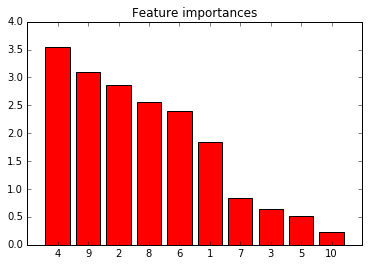



 Random Forest Classification C-V: 

Accuracy: 0.71 (+/- 0.14)
Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.147634)
2. feature 5 - 11A Front Rounded Vowels (0.144993)
3. feature 9 - 12A Syllable Structure (0.127156)
4. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.115955)
5. feature 3 - 7A Glottalized Consonants (0.113323)
6. feature 0 - 4A Voicing in Plosives and Fricatives (0.098507)
7. feature 6 - 13A Tone (0.069421)
8. feature 4 - 8A Lateral Consonants (0.068219)
9. feature 8 - 19A Presence of Uncommon Consonants (0.062454)
10. feature 7 - 18A Absence of Common Consonants (0.052336)


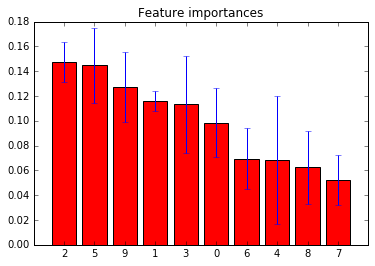


Extra Trees Classification: 

[ 0.625       0.54166667  0.75        0.79166667  0.73913043]
Accuracy: 0.69 (+/- 0.18)

Feature ranking:
1. feature 5 - 11A Front Rounded Vowels (0.155871)
2. feature 2 - 6A Uvular Consonants (0.149724)
3. feature 6 - 13A Tone (0.138050)
4. feature 0 - 4A Voicing in Plosives and Fricatives (0.109085)
5. feature 4 - 8A Lateral Consonants (0.094676)
6. feature 3 - 7A Glottalized Consonants (0.085765)
7. feature 9 - 12A Syllable Structure (0.074888)
8. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.066973)
9. feature 7 - 18A Absence of Common Consonants (0.066402)
10. feature 8 - 19A Presence of Uncommon Consonants (0.058565)


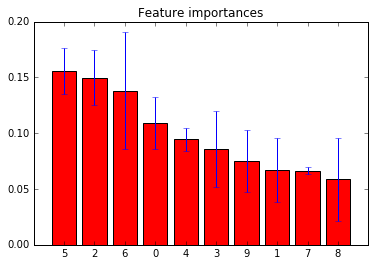


PERMUTATION TEST: 

Linear SVM - Classification score 0.722265480163 (pvalue : 0.00990099009901 )

Random Forest - Classification score 0.663895068595 (pvalue : 0.049504950495)

ARID AND POLAR - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.757744186047

 Linear SVM Classification C-V:
Accuracy: 0.72 (+/- 0.24)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 8 - 19A Presence of Uncommon Consonants (2.429510)
2. feature 5 - 11A Front Rounded Vowels (2.418466)
3. feature 3 - 7A Glottalized Consonants (1.940831)
4. feature 2 - 6A Uvular Consonants (1.917369)
5. feature 0 - 4A Voicing in Plosives and Fricatives (1.841134)
6. feature 4 - 8A Lateral Consonants (1.611200)
7. feature 1 - 5A Voicing and Gaps in Plosive Systems (1.371215)
8. feature 6 - 13A Tone (0.774394)
9. feature 9 - 12A Syllable Structure (0.744050)
10. feature 7 - 18A Absence of Common Consonants (0.435249)


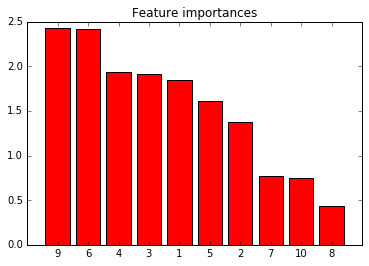



 Random Forest Classification C-V: 

Accuracy: 0.92 (+/- 0.09)
Feature ranking:
1. feature 5 - 11A Front Rounded Vowels (0.190431)
2. feature 0 - 4A Voicing in Plosives and Fricatives (0.181189)
3. feature 2 - 6A Uvular Consonants (0.161709)
4. feature 3 - 7A Glottalized Consonants (0.110457)
5. feature 9 - 12A Syllable Structure (0.104735)
6. feature 8 - 19A Presence of Uncommon Consonants (0.094132)
7. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.055452)
8. feature 4 - 8A Lateral Consonants (0.045606)
9. feature 6 - 13A Tone (0.038219)
10. feature 7 - 18A Absence of Common Consonants (0.018070)


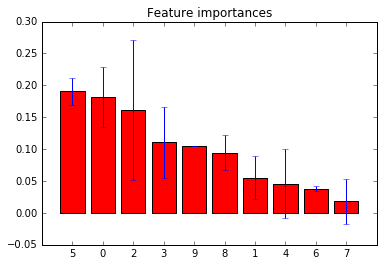


Extra Trees Classification: 

[ 0.83333333  0.83333333  0.94117647  0.94117647  0.9375    ]
Accuracy: 0.90 (+/- 0.10)

Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.261486)
2. feature 0 - 4A Voicing in Plosives and Fricatives (0.208096)
3. feature 5 - 11A Front Rounded Vowels (0.130243)
4. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.091960)
5. feature 9 - 12A Syllable Structure (0.089913)
6. feature 4 - 8A Lateral Consonants (0.053549)
7. feature 3 - 7A Glottalized Consonants (0.049557)
8. feature 6 - 13A Tone (0.041046)
9. feature 8 - 19A Presence of Uncommon Consonants (0.037846)
10. feature 7 - 18A Absence of Common Consonants (0.036304)


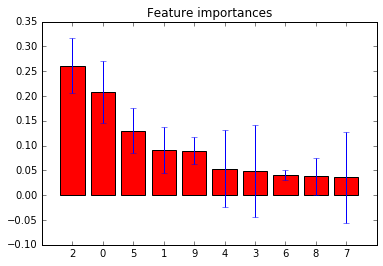


PERMUTATION TEST: 

Linear SVM - Classification score 0.86038961039 (pvalue : 0.00990099009901 )

Random Forest - Classification score 0.86038961039 (pvalue : 0.039603960396)

TEMPERATE AND COLD - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.574055172414

 Linear SVM Classification C-V:
Accuracy: 0.68 (+/- 0.26)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 3 - 7A Glottalized Consonants (3.010074)
2. feature 1 - 5A Voicing and Gaps in Plosive Systems (2.900000)
3. feature 7 - 18A Absence of Common Consonants (2.568609)
4. feature 2 - 6A Uvular Consonants (2.007287)
5. feature 6 - 13A Tone (1.710516)
6. feature 5 - 11A Front Rounded Vowels (1.549590)
7. feature 0 - 4A Voicing in Plosives and Fricatives (1.500702)
8. feature 9 - 12A Syllable Structure (1.125922)
9. feature 4 - 8A Lateral Consonants (0.912028)
10. feature 8 - 19A Presence of Uncommon Consonants (0.435230)


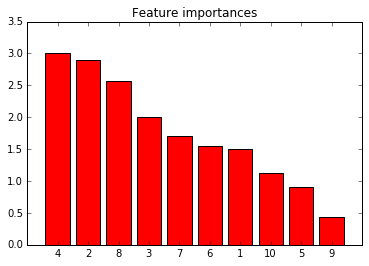



 Random Forest Classification C-V: 

Accuracy: 0.63 (+/- 0.15)
Feature ranking:
1. feature 3 - 7A Glottalized Consonants (0.136893)
2. feature 2 - 6A Uvular Consonants (0.133705)
3. feature 8 - 19A Presence of Uncommon Consonants (0.118335)
4. feature 0 - 4A Voicing in Plosives and Fricatives (0.110142)
5. feature 9 - 12A Syllable Structure (0.105979)
6. feature 4 - 8A Lateral Consonants (0.103589)
7. feature 5 - 11A Front Rounded Vowels (0.103136)
8. feature 6 - 13A Tone (0.099619)
9. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.056243)
10. feature 7 - 18A Absence of Common Consonants (0.032358)


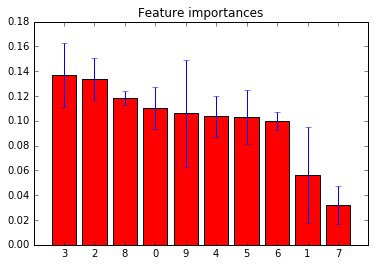


Extra Trees Classification: 

[ 0.51724138  0.34482759  0.65517241  0.5862069   0.68965517]
Accuracy: 0.56 (+/- 0.24)

Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.181366)
2. feature 3 - 7A Glottalized Consonants (0.139446)
3. feature 4 - 8A Lateral Consonants (0.118427)
4. feature 6 - 13A Tone (0.116226)
5. feature 0 - 4A Voicing in Plosives and Fricatives (0.087016)
6. feature 9 - 12A Syllable Structure (0.085380)
7. feature 8 - 19A Presence of Uncommon Consonants (0.083626)
8. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.074083)
9. feature 5 - 11A Front Rounded Vowels (0.071626)
10. feature 7 - 18A Absence of Common Consonants (0.042804)


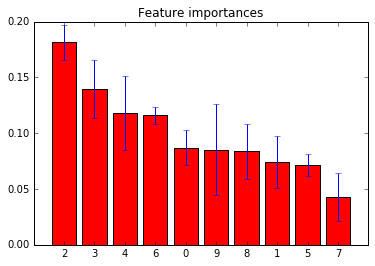


PERMUTATION TEST: 

Linear SVM - Classification score 0.600412912913 (pvalue : 0.0891089108911 )

Random Forest - Classification score 0.613363363363 (pvalue : 0.287128712871)

TEMPERATE AND POLAR - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.811035714286

 Linear SVM Classification C-V:
Accuracy: 0.76 (+/- 0.14)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 2 - 6A Uvular Consonants (3.808723)
2. feature 8 - 19A Presence of Uncommon Consonants (2.455001)
3. feature 4 - 8A Lateral Consonants (2.240000)
4. feature 6 - 13A Tone (2.216832)
5. feature 0 - 4A Voicing in Plosives and Fricatives (1.856212)
6. feature 5 - 11A Front Rounded Vowels (1.662764)
7. feature 3 - 7A Glottalized Consonants (1.309893)
8. feature 1 - 5A Voicing and Gaps in Plosive Systems (1.120000)
9. feature 9 - 12A Syllable Structure (1.056399)
10. feature 7 - 18A Absence of Common Consonants (0.229863)


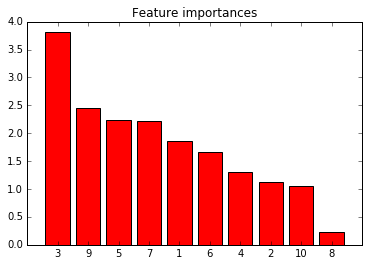



 Random Forest Classification C-V: 

Accuracy: 0.91 (+/- 0.11)
Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.243321)
2. feature 3 - 7A Glottalized Consonants (0.178189)
3. feature 0 - 4A Voicing in Plosives and Fricatives (0.171638)
4. feature 5 - 11A Front Rounded Vowels (0.105014)
5. feature 4 - 8A Lateral Consonants (0.070450)
6. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.069509)
7. feature 9 - 12A Syllable Structure (0.057037)
8. feature 8 - 19A Presence of Uncommon Consonants (0.053351)
9. feature 6 - 13A Tone (0.039638)
10. feature 7 - 18A Absence of Common Consonants (0.011852)


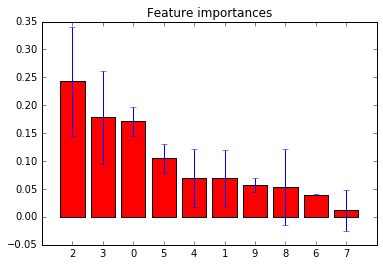


Extra Trees Classification: 

[ 0.86956522  0.86956522  0.86363636  0.90909091  0.95454545]
Accuracy: 0.89 (+/- 0.07)

Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.241582)
2. feature 0 - 4A Voicing in Plosives and Fricatives (0.134868)
3. feature 5 - 11A Front Rounded Vowels (0.112823)
4. feature 8 - 19A Presence of Uncommon Consonants (0.111909)
5. feature 3 - 7A Glottalized Consonants (0.102062)
6. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.087391)
7. feature 9 - 12A Syllable Structure (0.083804)
8. feature 6 - 13A Tone (0.052490)
9. feature 4 - 8A Lateral Consonants (0.041981)
10. feature 7 - 18A Absence of Common Consonants (0.031090)


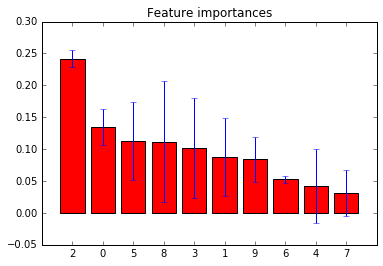


PERMUTATION TEST: 

Linear SVM - Classification score 0.821428571429 (pvalue : 0.00990099009901 )

Random Forest - Classification score 0.901785714286 (pvalue : 0.029702970297)

COLD AND POLAR - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.666105263158

 Linear SVM Classification C-V:
Accuracy: 0.56 (+/- 0.24)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 0 - 4A Voicing in Plosives and Fricatives (3.255538)
2. feature 5 - 11A Front Rounded Vowels (2.553106)
3. feature 8 - 19A Presence of Uncommon Consonants (1.866719)
4. feature 3 - 7A Glottalized Consonants (1.713296)
5. feature 2 - 6A Uvular Consonants (1.444599)
6. feature 4 - 8A Lateral Consonants (1.299596)
7. feature 1 - 5A Voicing and Gaps in Plosive Systems (1.266667)
8. feature 7 - 18A Absence of Common Consonants (0.377086)
9. feature 9 - 12A Syllable Structure (0.103342)
10. feature 6 - 13A Tone (0.000308)


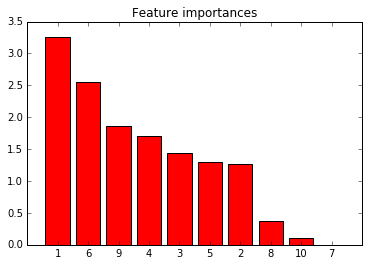



 Random Forest Classification C-V: 

Accuracy: 0.77 (+/- 0.09)
Feature ranking:
1. feature 5 - 11A Front Rounded Vowels (0.159090)
2. feature 2 - 6A Uvular Consonants (0.151383)
3. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.132458)
4. feature 0 - 4A Voicing in Plosives and Fricatives (0.115334)
5. feature 9 - 12A Syllable Structure (0.108534)
6. feature 3 - 7A Glottalized Consonants (0.103089)
7. feature 8 - 19A Presence of Uncommon Consonants (0.091347)
8. feature 6 - 13A Tone (0.052208)
9. feature 4 - 8A Lateral Consonants (0.049737)
10. feature 7 - 18A Absence of Common Consonants (0.036821)


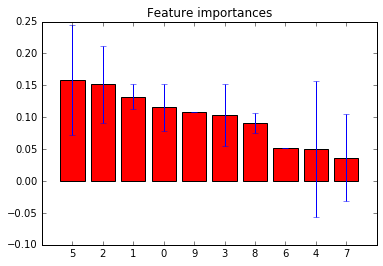


Extra Trees Classification: 

[ 0.83333333  0.75        0.63636364  0.72727273  0.72727273]
Accuracy: 0.73 (+/- 0.13)

Feature ranking:
1. feature 9 - 12A Syllable Structure (0.186803)
2. feature 8 - 19A Presence of Uncommon Consonants (0.158113)
3. feature 3 - 7A Glottalized Consonants (0.112152)
4. feature 0 - 4A Voicing in Plosives and Fricatives (0.109782)
5. feature 5 - 11A Front Rounded Vowels (0.107027)
6. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.087231)
7. feature 2 - 6A Uvular Consonants (0.077784)
8. feature 4 - 8A Lateral Consonants (0.073972)
9. feature 6 - 13A Tone (0.054003)
10. feature 7 - 18A Absence of Common Consonants (0.033132)


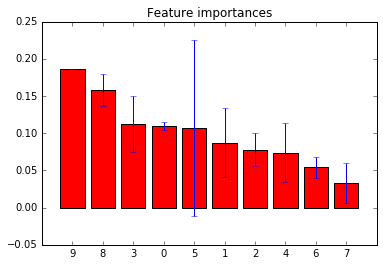


PERMUTATION TEST: 

Linear SVM - Classification score 0.683333333333 (pvalue : 0.108910891089 )

Random Forest - Classification score 0.736904761905 (pvalue : 0.376237623762)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [288]:
#Phonological - Binary Classifications

#Binary classification for each climate

binary_clas(phon_df, phon_feat, subsets)


Dummy Classifier
0.564393120393
Linear SVM Classification C-V:
[ 0.6626506   0.61728395  0.67901235  0.67901235  0.71604938]
Accuracy: 0.67 (+/- 0.06)
Linear SVM Feature Importance:
Feature ranking:
1. feature 4 - 8A Lateral Consonants (2.913916)
2. feature 2 - 6A Uvular Consonants (2.771900)
3. feature 1 - 5A Voicing and Gaps in Plosive Systems (1.657615)
4. feature 5 - 11A Front Rounded Vowels (1.489452)
5. feature 8 - 19A Presence of Uncommon Consonants (1.175525)
6. feature 0 - 4A Voicing in Plosives and Fricatives (0.843772)
7. feature 6 - 13A Tone (0.822506)
8. feature 7 - 18A Absence of Common Consonants (0.789347)
9. feature 9 - 12A Syllable Structure (0.752992)
10. feature 3 - 7A Glottalized Consonants (0.651766)


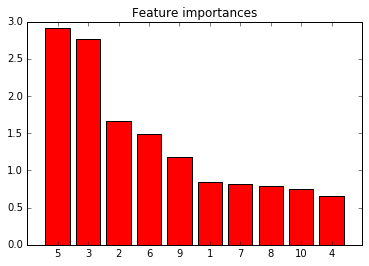


Random Forest Classification:
[ 0.72289157  0.69135802  0.69135802  0.75308642  0.75308642]
Accuracy: 0.72 (+/- 0.06)
Feature ranking:
1. feature 3 - 7A Glottalized Consonants (0.120195)
2. feature 2 - 6A Uvular Consonants (0.116432)
3. feature 0 - 4A Voicing in Plosives and Fricatives (0.104338)
4. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.087932)
5. feature 8 - 19A Presence of Uncommon Consonants (0.073475)
6. feature 5 - 11A Front Rounded Vowels (0.067040)
7. feature 7 - 18A Absence of Common Consonants (0.054117)
8. feature 4 - 8A Lateral Consonants (0.052262)
9. feature 9 - 12A Syllable Structure (0.050178)
10. feature 6 - 13A Tone (0.029380)


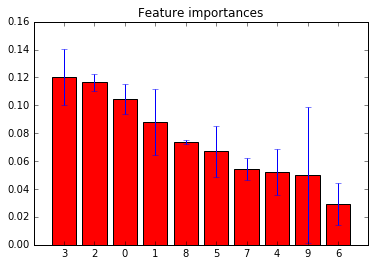


Extra Trees Classification:
[ 0.72289157  0.69135802  0.71604938  0.72839506  0.75308642]
Accuracy: 0.72 (+/- 0.04)
Feature ranking:
1. feature 3 - 7A Glottalized Consonants (0.133398)
2. feature 2 - 6A Uvular Consonants (0.102924)
3. feature 0 - 4A Voicing in Plosives and Fricatives (0.095986)
4. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.090064)
5. feature 5 - 11A Front Rounded Vowels (0.084579)
6. feature 8 - 19A Presence of Uncommon Consonants (0.074346)
7. feature 4 - 8A Lateral Consonants (0.048493)
8. feature 7 - 18A Absence of Common Consonants (0.042067)
9. feature 9 - 12A Syllable Structure (0.041053)
10. feature 6 - 13A Tone (0.027437)


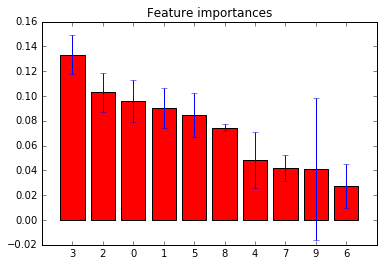

In [50]:
#Binary Group Classification
#Arid,Cold,Polar(H) vs Tropical,Temperate(I)

y_ = lb.inverse_transform(y_phon)
for l in range(0,len(y_)):
    if y_[l]=='A' or y_[l]=='C':
        y_[l] = 'H'
    else:
        y_[l] = 'I'

def class_grouped(x,y,feat):
    #lb = preprocessing.LabelBinarizer()
    #lb.fit(y)
    #y = lb.transform(y)
    print("Dummy Classifier")
    dummyclas.fit(x,y)
    print(dummy_clas(dummyclas, x, y))
    
    rf = RandomForestClassifier(class_weight = 'balanced')
    sv = svm.SVC(kernel= "linear", class_weight = 'balanced')
    et = ExtraTreesClassifier(random_state=0, class_weight = 'balanced')
    trained_model = rf.fit(x,y)
    cvsv = cross_val_score(sv, x, y, cv=5)
    t_m = et.fit(x, y)
    
    print("Linear SVM Classification C-V:")
    print(cvsv)
    print("Accuracy: %0.2f (+/- %0.2f)" % (cvsv.mean(), cvsv.std() * 2))
    
    print("Linear SVM Feature Importance:")
    svm_feat_imp(sv, x, y, feat)
    cvrf = cross_val_score(rf, x, y, cv=5)
    print()
    
    print("Random Forest Classification:")
    print(cvrf)
    print("Accuracy: %0.2f (+/- %0.2f)" % (cvrf.mean(), cvrf.std() * 2))
    RFC_feat_imp(trained_model, feat, x, y)
    print()
    
    print("Extra Trees Classification:")
    etcv = cross_val_score(et, x, y, cv=5)
    print(etcv)
    print("Accuracy: %0.2f (+/- %0.2f)" % (etcv.mean(), etcv.std() * 2))
    RFC_feat_imp(t_m, feat, x, y)
    
class_grouped(x_phon, y_, phon_feat)

Dummy Classifier
0.525302211302
Linear SVM Classification C-V:
[ 0.64634146  0.80487805  0.7037037   0.69135802  0.71604938]
Accuracy: 0.71 (+/- 0.10)
Linear SVM Feature Importance:
Feature ranking:
1. feature 4 - 8A Lateral Consonants (2.676331)
2. feature 1 - 5A Voicing and Gaps in Plosive Systems (2.642577)
3. feature 2 - 6A Uvular Consonants (1.741842)
4. feature 5 - 11A Front Rounded Vowels (1.570752)
5. feature 6 - 13A Tone (1.215128)
6. feature 3 - 7A Glottalized Consonants (0.815997)
7. feature 9 - 12A Syllable Structure (0.490503)
8. feature 8 - 19A Presence of Uncommon Consonants (0.385261)
9. feature 0 - 4A Voicing in Plosives and Fricatives (0.325769)
10. feature 7 - 18A Absence of Common Consonants (0.279178)


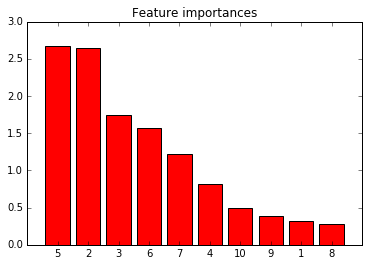


Random Forest Classification:
[ 0.68292683  0.84146341  0.60493827  0.74074074  0.66666667]
Accuracy: 0.71 (+/- 0.16)
Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.126009)
2. feature 0 - 4A Voicing in Plosives and Fricatives (0.110094)
3. feature 3 - 7A Glottalized Consonants (0.103929)
4. feature 8 - 19A Presence of Uncommon Consonants (0.092168)
5. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.077731)
6. feature 7 - 18A Absence of Common Consonants (0.069009)
7. feature 5 - 11A Front Rounded Vowels (0.068823)
8. feature 4 - 8A Lateral Consonants (0.066656)
9. feature 9 - 12A Syllable Structure (0.033769)
10. feature 6 - 13A Tone (0.029504)


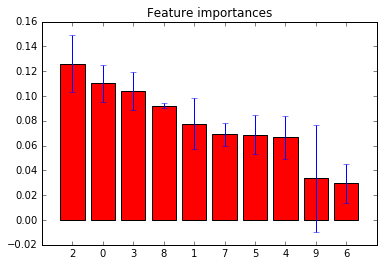


Extra Trees Classification:
[ 0.69512195  0.84146341  0.60493827  0.69135802  0.72839506]
Accuracy: 0.71 (+/- 0.15)
Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.129609)
2. feature 0 - 4A Voicing in Plosives and Fricatives (0.111264)
3. feature 3 - 7A Glottalized Consonants (0.098744)
4. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.088911)
5. feature 8 - 19A Presence of Uncommon Consonants (0.085084)
6. feature 5 - 11A Front Rounded Vowels (0.085018)
7. feature 4 - 8A Lateral Consonants (0.071231)
8. feature 7 - 18A Absence of Common Consonants (0.053256)
9. feature 9 - 12A Syllable Structure (0.044050)
10. feature 6 - 13A Tone (0.027178)


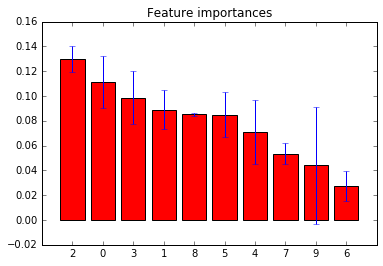

In [51]:
#Binary GROUP Classification
#Tropical,Arid (F) vs Temperate, Cold, Polar (G)

y_ = lb.inverse_transform(y_phon)
for l in range(0,len(y_)):
    if y_[l]=='A' or y_[l]=='B':
        y_[l] = 'F'
    else:
        y_[l] = 'G'
        
class_grouped(x_phon,y_,phon_feat)


Dummy Classifier
0.510732186732
Linear SVM Classification C-V:
[ 0.56097561  0.58536585  0.5         0.59259259  0.6125    ]
Accuracy: 0.57 (+/- 0.08)
Linear SVM Feature Importance:
Feature ranking:
1. feature 5 - 11A Front Rounded Vowels (3.055397)
2. feature 2 - 6A Uvular Consonants (2.407536)
3. feature 3 - 7A Glottalized Consonants (2.187744)
4. feature 1 - 5A Voicing and Gaps in Plosive Systems (1.891186)
5. feature 4 - 8A Lateral Consonants (1.841735)
6. feature 9 - 12A Syllable Structure (1.091308)
7. feature 6 - 13A Tone (1.057790)
8. feature 8 - 19A Presence of Uncommon Consonants (0.504162)
9. feature 7 - 18A Absence of Common Consonants (0.420162)
10. feature 0 - 4A Voicing in Plosives and Fricatives (0.340744)


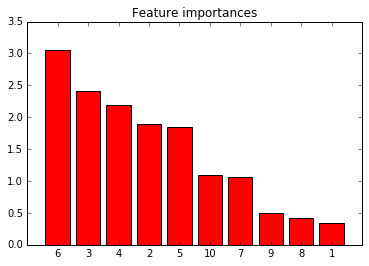


Random Forest Classification:
[ 0.57317073  0.6097561   0.48780488  0.54320988  0.725     ]
Accuracy: 0.59 (+/- 0.16)
Feature ranking:
1. feature 3 - 7A Glottalized Consonants (0.108535)
2. feature 0 - 4A Voicing in Plosives and Fricatives (0.101069)
3. feature 2 - 6A Uvular Consonants (0.094709)
4. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.092934)
5. feature 5 - 11A Front Rounded Vowels (0.079438)
6. feature 4 - 8A Lateral Consonants (0.071904)
7. feature 8 - 19A Presence of Uncommon Consonants (0.062058)
8. feature 9 - 12A Syllable Structure (0.042678)
9. feature 7 - 18A Absence of Common Consonants (0.040546)
10. feature 6 - 13A Tone (0.029944)


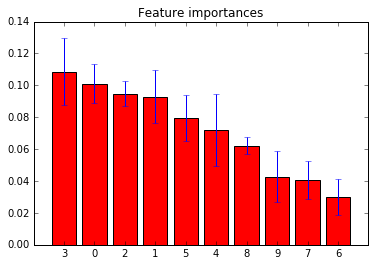


Extra Trees Classification:
[ 0.57317073  0.64634146  0.48780488  0.56790123  0.65      ]
Accuracy: 0.59 (+/- 0.12)
Feature ranking:
1. feature 0 - 4A Voicing in Plosives and Fricatives (0.120378)
2. feature 3 - 7A Glottalized Consonants (0.107029)
3. feature 8 - 19A Presence of Uncommon Consonants (0.100279)
4. feature 5 - 11A Front Rounded Vowels (0.090164)
5. feature 2 - 6A Uvular Consonants (0.085176)
6. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.077778)
7. feature 4 - 8A Lateral Consonants (0.073796)
8. feature 9 - 12A Syllable Structure (0.047300)
9. feature 6 - 13A Tone (0.028300)
10. feature 7 - 18A Absence of Common Consonants (0.022111)


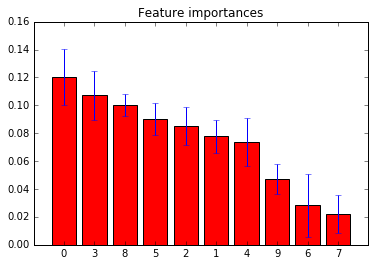

In [52]:
#Binary Group Classification
#Arid,Temperate(J) vs Tropical,Cold,Polar(K)
y_ = lb.inverse_transform(y_phon)
for l in range(0,len(y_)):
    if y_[l]=='B' or y_[l]=='C':
        y_[l] = 'J'
    else:
        y_[l] = 'K'

class_grouped(x_phon,y_,phon_feat)

Dummy Classifier
0.508992628993
Linear SVM Classification C-V:
[ 0.72289157  0.71604938  0.69135802  0.74074074  0.79012346]
Accuracy: 0.73 (+/- 0.07)
Linear SVM Feature Importance:
Feature ranking:
1. feature 4 - 8A Lateral Consonants (3.148049)
2. feature 2 - 6A Uvular Consonants (2.781491)
3. feature 5 - 11A Front Rounded Vowels (2.656060)
4. feature 6 - 13A Tone (1.895467)
5. feature 3 - 7A Glottalized Consonants (1.604718)
6. feature 1 - 5A Voicing and Gaps in Plosive Systems (1.079402)
7. feature 7 - 18A Absence of Common Consonants (0.930727)
8. feature 8 - 19A Presence of Uncommon Consonants (0.285371)
9. feature 9 - 12A Syllable Structure (0.266868)
10. feature 0 - 4A Voicing in Plosives and Fricatives (0.110591)


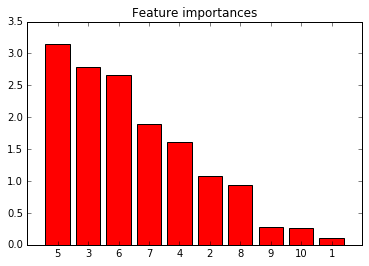


Random Forest Classification:
[ 0.71084337  0.77777778  0.64197531  0.66666667  0.69135802]
Accuracy: 0.70 (+/- 0.09)
Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.126719)
2. feature 0 - 4A Voicing in Plosives and Fricatives (0.107337)
3. feature 3 - 7A Glottalized Consonants (0.104703)
4. feature 5 - 11A Front Rounded Vowels (0.104173)
5. feature 8 - 19A Presence of Uncommon Consonants (0.071874)
6. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.066384)
7. feature 4 - 8A Lateral Consonants (0.059358)
8. feature 9 - 12A Syllable Structure (0.040440)
9. feature 6 - 13A Tone (0.023625)
10. feature 7 - 18A Absence of Common Consonants (0.019057)


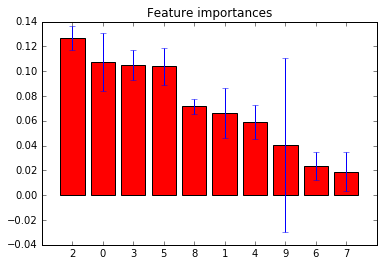


Extra Trees Classification:
[ 0.69879518  0.7654321   0.67901235  0.7037037   0.75308642]
Accuracy: 0.72 (+/- 0.07)
Feature ranking:
1. feature 2 - 6A Uvular Consonants (0.132969)
2. feature 0 - 4A Voicing in Plosives and Fricatives (0.106691)
3. feature 5 - 11A Front Rounded Vowels (0.101660)
4. feature 8 - 19A Presence of Uncommon Consonants (0.079556)
5. feature 3 - 7A Glottalized Consonants (0.076510)
6. feature 1 - 5A Voicing and Gaps in Plosive Systems (0.067047)
7. feature 4 - 8A Lateral Consonants (0.064074)
8. feature 9 - 12A Syllable Structure (0.042254)
9. feature 7 - 18A Absence of Common Consonants (0.026143)
10. feature 6 - 13A Tone (0.021228)


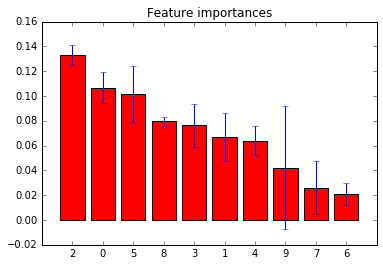

In [53]:
#Binary Group Classification
#Tropical(L) vs Temperate,Cold,Polar(M)

y_ = lb.inverse_transform(y_phon)
for l in range(0,len(y_)):
    if y_[l]=='A':
        y_[l] = 'L'
    else:
        y_[l] = 'M'
        
class_grouped(x_phon,y_,phon_feat)

In [208]:
#MORPHOLOGY
#Same classification procedure for 8 Morphology Features - 23A, 24A, 25A, 25B, 26A, 27A, 28A, 29A

df2 = lang_df[lang_df['23A Locus of Marking in the Clause'].notnull() & lang_df['24A Locus of Marking in Possessive Noun Phrases'].notnull() & lang_df['25A Locus of Marking: Whole-language Typology'].notnull() & lang_df['26A Prefixing vs. Suffixing in Inflectional Morphology'].notnull() 
& lang_df['27A Reduplication'].notnull()& lang_df['28A Case Syncretism'].notnull()& lang_df['29A Syncretism in Verbal Person/Number Marking'].notnull()]

ft = ['23A Locus of Marking in the Clause','24A Locus of Marking in Possessive Noun Phrases','25A Locus of Marking: Whole-language Typology','26A Prefixing vs. Suffixing in Inflectional Morphology', '27A Reduplication','28A Case Syncretism','29A Syncretism in Verbal Person/Number Marking']
#pre-proccesing
F,P = df_list(ft, df2)
Cl= pd.Series.tolist(df2['Climate'])
stats_out(Cl)




A - Tropical: 29
B - Arid: 18
C - Temperate: 29
D - Cold: 12
E - Polar: 3


In [209]:
#Pre-proccessing OHE
e = OneHotEncoder()
F = e.fit_transform(F).toarray()
lb.fit(P)
P = lb.transform(P)

dummyclas.fit(F, lb.inverse_transform(P))

scores_1 = cross_val_score(sv_ovr, F, P, cv=5)
scores_2 = cross_val_score(svmm, F, P, cv=5)

print("C-V scores, Method 1  - OHE : ")
print(scores_1)

print("C-V scores, Method 2  - OHE :")
print(scores_2)
print(dummy_clas(dummyclas, F, lb.inverse_transform(P)))
print("Accuracy for C-V (95 CI) , Method 1  - OHE : %0.2f (+/- %0.2f)" % (scores_1.mean(), scores_1.std() * 2))
print("Accuracy for C-V (95 CI), Method 2  - OHE : %0.2f (+/- %0.2f)" % (scores_2.mean(), scores_2.std() * 2))

print("Accuracy Dummy Classifier")
print(dummy_clas(dummyclas, x_phon, lb.inverse_transform(y_phon)))


C-V scores, Method 1  - OHE : 
[ 0.15789474  0.27777778  0.11111111  0.11111111  0.11111111]
C-V scores, Method 2  - OHE :
[ 0.26315789  0.16666667  0.11111111  0.05555556  0.05555556]
0.262813186813
Accuracy for C-V (95 CI) , Method 1  - OHE : 0.15 (+/- 0.13)
Accuracy for C-V (95 CI), Method 2  - OHE : 0.13 (+/- 0.16)
Accuracy Dummy Classifier
0.269385749386


In [134]:
#One v Rest SVM linear and Random Forest classifier and CV 
classify = OneVsRestClassifier(estimator=SVC(random_state=0))

predic = classify.fit(F, P).predict(F)

In [136]:
sv_ovr = OneVsRestClassifier(LinearSVC(random_state=0, class_weight='balanced'))
sv_ovr.fit(F, P)
pred = sv_ovr.predict(F)
yn_phon = lb.inverse_transform(P)
pred = lb.inverse_transform(pred)
y_actu = pd.Series(yn_phon, name='Actual')
y_pred = pd.Series(pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,A,B,C,D,E
Actual,,,,,
A,25,1,2,1,0
B,5,13,0,0,0
C,6,7,16,0,0
D,1,2,7,2,0
E,0,1,0,0,2


In [137]:
#Simple accuracy of SVM
c=0
for i in range(0, len(P)):
    if P[i]== predic[i]:
        c=c+1
c/len(P)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


 Feature ranking:
1. feature 4 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.287885)
2. feature 1 - 23A Locus of Marking in the Clause (0.169218)
3. feature 2 - 24A Locus of Marking in Possessive Noun Phrases (0.140342)
4. feature 3 - 25A Locus of Marking: Whole-language Typology (0.138921)
5. feature 6 - 28A Case Syncretism (0.118546)
6. feature 7 - 29A Syncretism in Verbal Person/Number Marking (0.088837)
7. feature 5 - 27A Reduplication (0.056252)


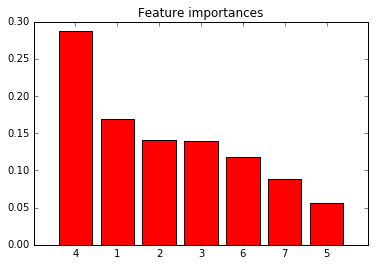

In [192]:
#Feature Importance - for each list j, represents the jth feature vs Rest linear SVM's coefficient

sv_ovr.fit(F, P)
coef = sv_ovr.coef_

a = np.absolute(coef)
b = np.sum(a, axis=0)
b = np.square(b)
s = sum(b)
feat = np.true_divide(b,s)
feat = np.asarray(feat)
feat = feat.tolist()

feat = feat_imp_ohe(e.feature_indices_, e.active_features_, feat)

ind = np.argsort(feat)[::-1]

print("\n Feature ranking:")


for f in range(len(feat)):
    print("%d. feature %d - %s (%f)" % (f + 1, ind[f] + 1, ft[ind[f]], feat[ind[f]]))
    
feat = np.asarray(feat)
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(feat)), feat[ind],
       color="r", align="center")
plt.xticks(range(len(feat)), ind+1)
plt.xlim([-1, len(feat)])
plt.show()




In [195]:
#MORPHOLOGY RANDOM FOREST
train_f, test_f, train_p, test_p = train_test_split(F, P)
rfc.fit(F, P)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [197]:
trained_mod = rfc.fit(train_f, train_p)
trained_mod


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [198]:
predictions = trained_model.predict(test_f)
test_p = lb.inverse_transform(test_p)
predictions = lb.inverse_transform(predictions)
print("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print("Test Accuracy  :: ", accuracy_score(test_y, predictions))

Train Accuracy ::  0.764705882353


ValueError: Can't handle mix of multilabel-indicator and multiclass

Feature ranking:
1. feature 4 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.214138)
2. feature 6 - 28A Case Syncretism (0.174171)
3. feature 5 - 27A Reduplication (0.153477)
4. feature 2 - 24A Locus of Marking in Possessive Noun Phrases (0.127480)
5. feature 1 - 23A Locus of Marking in the Clause (0.125409)
6. feature 7 - 29A Syncretism in Verbal Person/Number Marking (0.113255)
7. feature 3 - 25A Locus of Marking: Whole-language Typology (0.092070)


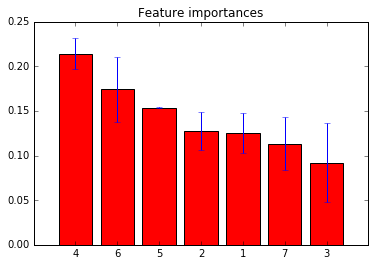

In [200]:
#Feature Importance

importances = trained_mod.feature_importances_
std = np.std([tree.feature_importances_ for tree in trained_model.estimators_],
             axis=0)

importances = importances.tolist()

# Print the feature ranking
print("Feature ranking:")

X = np.asarray(F)


importances = feat_imp_ohe(e.feature_indices_, e.active_features_, importances)

indices = np.argsort(importances)[::-1]

for f in range(0,len(importances)):
    print("%d. feature %d - %s (%f)" % ( f + 1 , indices[f] + 1, ft[indices[f]], importances[indices[f]]))
    
importances = np.asarray(importances)
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(importances)), (indices+1))
plt.xlim([-1, len(importances)])
plt.show()



TROPICAL AND ARID - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.52714893617

 Linear SVM Classification C-V:
Accuracy: 0.47 (+/- 0.12)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (4.497081)
2. feature 5 - 28A Case Syncretism (1.761710)
3. feature 6 - 29A Syncretism in Verbal Person/Number Marking (1.521594)
4. feature 0 - 23A Locus of Marking in the Clause (1.377636)
5. feature 4 - 27A Reduplication (0.932355)
6. feature 2 - 25A Locus of Marking: Whole-language Typology (0.875775)
7. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.667444)


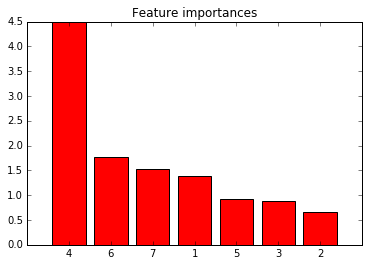



 Random Forest Classification C-V: 

Accuracy: 0.60 (+/- 0.20)
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.240723)
2. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.220337)
3. feature 0 - 23A Locus of Marking in the Clause (0.182892)
4. feature 5 - 28A Case Syncretism (0.128378)
5. feature 2 - 25A Locus of Marking: Whole-language Typology (0.095956)
6. feature 4 - 27A Reduplication (0.067759)
7. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.063955)


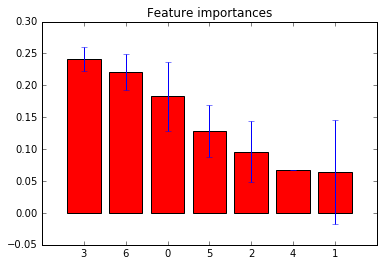


Extra Trees Classification: 

[ 0.6         0.6         0.7         0.66666667  0.625     ]
Accuracy: 0.64 (+/- 0.08)

Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.280195)
2. feature 0 - 23A Locus of Marking in the Clause (0.173158)
3. feature 5 - 28A Case Syncretism (0.171836)
4. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.112948)
5. feature 4 - 27A Reduplication (0.097333)
6. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.089322)
7. feature 2 - 25A Locus of Marking: Whole-language Typology (0.075207)


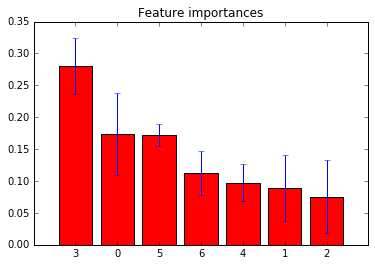


PERMUTATION TEST: 

Linear SVM - Classification score 0.521707459207 (pvalue : 0.425742574257 )

Random Forest - Classification score 0.542540792541 (pvalue : 0.49504950495)

TROPICAL AND TEMPERATE - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.496517241379

 Linear SVM Classification C-V:
Accuracy: 0.50 (+/- 0.09)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (2.200999)
2. feature 0 - 23A Locus of Marking in the Clause (2.097912)
3. feature 5 - 28A Case Syncretism (2.000000)
4. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (1.381805)
5. feature 6 - 29A Syncretism in Verbal Person/Number Marking (1.378320)
6. feature 2 - 25A Locus of Marking: Whole-language Typology (1.139057)
7. feature 4 - 27A Reduplication (1.019477)


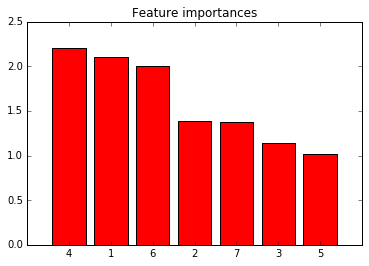



 Random Forest Classification C-V: 

Accuracy: 0.48 (+/- 0.07)
Feature ranking:
1. feature 0 - 23A Locus of Marking in the Clause (0.233541)
2. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.147586)
3. feature 4 - 27A Reduplication (0.146560)
4. feature 5 - 28A Case Syncretism (0.138037)
5. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.131471)
6. feature 2 - 25A Locus of Marking: Whole-language Typology (0.110212)
7. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.092594)


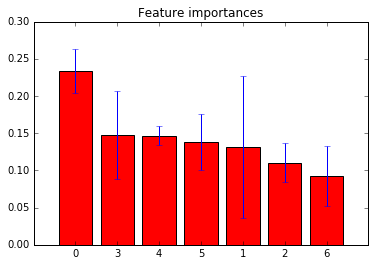


Extra Trees Classification: 

[ 0.58333333  0.5         0.41666667  0.58333333  0.7       ]
Accuracy: 0.56 (+/- 0.19)

Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.206986)
2. feature 0 - 23A Locus of Marking in the Clause (0.184925)
3. feature 5 - 28A Case Syncretism (0.147073)
4. feature 2 - 25A Locus of Marking: Whole-language Typology (0.138434)
5. feature 4 - 27A Reduplication (0.116316)
6. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.103403)
7. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.102863)


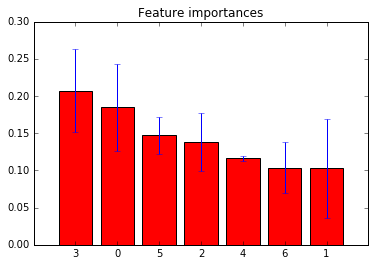


PERMUTATION TEST: 

Linear SVM - Classification score 0.522321428571 (pvalue : 0.326732673267 )

Random Forest - Classification score 0.53125 (pvalue : 0.316831683168)

TROPICAL AND COLD - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.582536585366

 Linear SVM Classification C-V:
Accuracy: 0.46 (+/- 0.19)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 0 - 23A Locus of Marking in the Clause (3.503075)
2. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (2.342590)
3. feature 2 - 25A Locus of Marking: Whole-language Typology (2.129328)
4. feature 6 - 29A Syncretism in Verbal Person/Number Marking (1.629784)
5. feature 5 - 28A Case Syncretism (1.449404)
6. feature 4 - 27A Reduplication (0.858215)
7. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.743084)


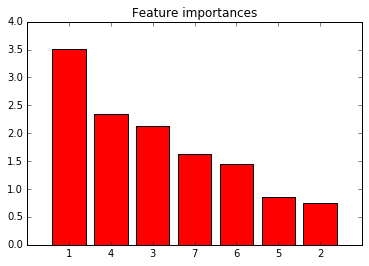



 Random Forest Classification C-V: 

Accuracy: 0.66 (+/- 0.24)
Feature ranking:
1. feature 4 - 27A Reduplication (0.230800)
2. feature 5 - 28A Case Syncretism (0.212274)
3. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.168775)
4. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.119258)
5. feature 0 - 23A Locus of Marking in the Clause (0.114398)
6. feature 2 - 25A Locus of Marking: Whole-language Typology (0.081807)
7. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.072687)


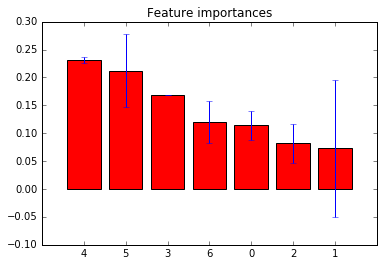


Extra Trees Classification: 

[ 0.33333333  0.77777778  0.75        0.75        0.71428571]
Accuracy: 0.67 (+/- 0.33)

Feature ranking:
1. feature 4 - 27A Reduplication (0.293332)
2. feature 0 - 23A Locus of Marking in the Clause (0.154043)
3. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.133144)
4. feature 5 - 28A Case Syncretism (0.123453)
5. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.112892)
6. feature 2 - 25A Locus of Marking: Whole-language Typology (0.108838)
7. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.074298)


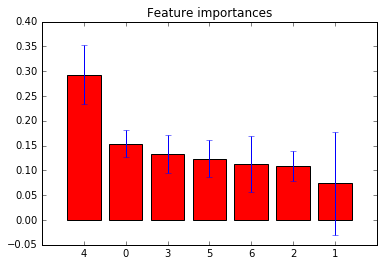


PERMUTATION TEST: 

Linear SVM - Classification score 0.536363636364 (pvalue : 0.574257425743 )

Random Forest - Classification score 0.563636363636 (pvalue : 0.871287128713)

ARID AND TEMPERATE - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.527063829787

 Linear SVM Classification C-V:
Accuracy: 0.42 (+/- 0.19)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (4.612516)
2. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (2.176947)
3. feature 4 - 27A Reduplication (1.693098)
4. feature 0 - 23A Locus of Marking in the Clause (1.499954)
5. feature 2 - 25A Locus of Marking: Whole-language Typology (1.421732)
6. feature 6 - 29A Syncretism in Verbal Person/Number Marking (1.178230)
7. feature 5 - 28A Case Syncretism (0.604544)


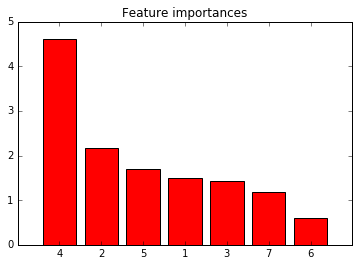



 Random Forest Classification C-V: 

Accuracy: 0.41 (+/- 0.35)
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.223990)
2. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.173710)
3. feature 5 - 28A Case Syncretism (0.148221)
4. feature 2 - 25A Locus of Marking: Whole-language Typology (0.129831)
5. feature 4 - 27A Reduplication (0.124758)
6. feature 0 - 23A Locus of Marking in the Clause (0.106887)
7. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.092602)


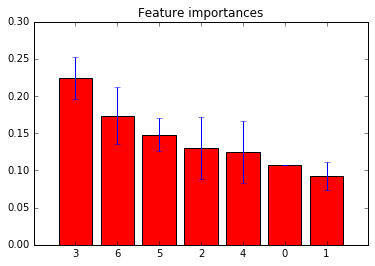


Extra Trees Classification: 

[ 0.7         0.1         0.6         0.55555556  0.5       ]
Accuracy: 0.49 (+/- 0.41)

Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.255190)
2. feature 5 - 28A Case Syncretism (0.172555)
3. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.159024)
4. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.123632)
5. feature 4 - 27A Reduplication (0.122925)
6. feature 2 - 25A Locus of Marking: Whole-language Typology (0.086792)
7. feature 0 - 23A Locus of Marking in the Clause (0.079882)


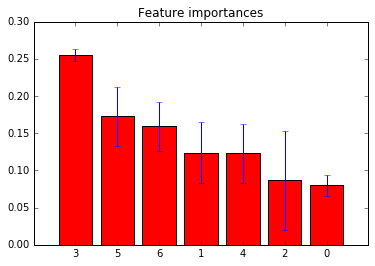


PERMUTATION TEST: 

Linear SVM - Classification score 0.404865967366 (pvalue : 0.940594059406 )

Random Forest - Classification score 0.478146853147 (pvalue : 0.653465346535)

ARID AND COLD - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.521733333333

 Linear SVM Classification C-V:
Accuracy: 0.67 (+/- 0.26)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 4 - 27A Reduplication (2.022819)
2. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (1.913638)
3. feature 2 - 25A Locus of Marking: Whole-language Typology (1.500094)
4. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (1.408030)
5. feature 0 - 23A Locus of Marking in the Clause (1.386144)
6. feature 5 - 28A Case Syncretism (1.127161)
7. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.591473)


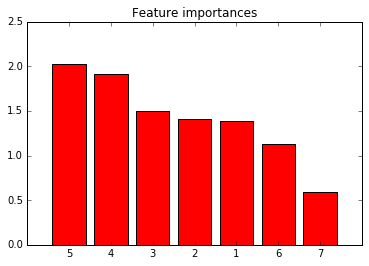



 Random Forest Classification C-V: 

Accuracy: 0.56 (+/- 0.36)
Feature ranking:
1. feature 4 - 27A Reduplication (0.234166)
2. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.218406)
3. feature 0 - 23A Locus of Marking in the Clause (0.154932)
4. feature 5 - 28A Case Syncretism (0.137318)
5. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.103824)
6. feature 2 - 25A Locus of Marking: Whole-language Typology (0.096600)
7. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.054754)


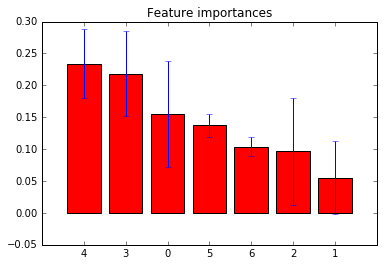


Extra Trees Classification: 

[ 0.57142857  0.85714286  0.5         0.8         0.6       ]
Accuracy: 0.67 (+/- 0.28)

Feature ranking:
1. feature 4 - 27A Reduplication (0.222287)
2. feature 5 - 28A Case Syncretism (0.158225)
3. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.141291)
4. feature 0 - 23A Locus of Marking in the Clause (0.141168)
5. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.129607)
6. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.116285)
7. feature 2 - 25A Locus of Marking: Whole-language Typology (0.091136)


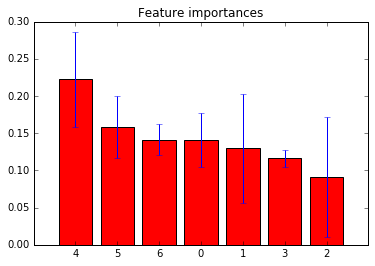


PERMUTATION TEST: 

Linear SVM - Classification score 0.629464285714 (pvalue : 0.118811881188 )

Random Forest - Classification score 0.665178571429 (pvalue : 0.0792079207921)

TEMPERATE AND COLD - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.582195121951

 Linear SVM Classification C-V:
Accuracy: 0.59 (+/- 0.15)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 4 - 27A Reduplication (2.446208)
2. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (2.209185)
3. feature 6 - 29A Syncretism in Verbal Person/Number Marking (1.921199)
4. feature 2 - 25A Locus of Marking: Whole-language Typology (1.906083)
5. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (1.827772)
6. feature 0 - 23A Locus of Marking in the Clause (1.194135)
7. feature 5 - 28A Case Syncretism (0.559130)


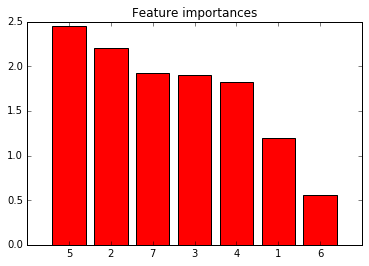



 Random Forest Classification C-V: 

Accuracy: 0.59 (+/- 0.15)
Feature ranking:
1. feature 4 - 27A Reduplication (0.197204)
2. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.193035)
3. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.141084)
4. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.140715)
5. feature 0 - 23A Locus of Marking in the Clause (0.137439)
6. feature 5 - 28A Case Syncretism (0.132527)
7. feature 2 - 25A Locus of Marking: Whole-language Typology (0.057996)


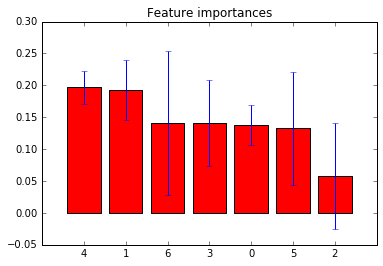


Extra Trees Classification: 

[ 0.66666667  0.55555556  0.5         0.5         0.57142857]
Accuracy: 0.56 (+/- 0.12)

Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.223780)
2. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.175522)
3. feature 4 - 27A Reduplication (0.169355)
4. feature 5 - 28A Case Syncretism (0.150504)
5. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.144678)
6. feature 2 - 25A Locus of Marking: Whole-language Typology (0.076142)
7. feature 0 - 23A Locus of Marking in the Clause (0.060019)


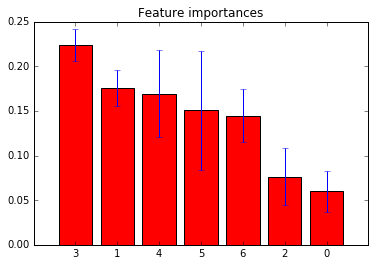


PERMUTATION TEST: 

Linear SVM - Classification score 0.538636363636 (pvalue : 0.405940594059 )

Random Forest - Classification score 0.659090909091 (pvalue : 0.227722772277)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [118]:
#Binary Classification Morphology
#Remove Polar insufficient samples
sub = [['A','B'],['A','C'],['A','D'],['B','C'],['B','D'],['C','D']]
binary_clas(df2, ft, sub)

Dummy Classifier
0.538087912088
Linear SVM Classification C-V:
[ 0.42105263  0.52631579  0.52631579  0.41176471  0.64705882]
Accuracy: 0.51 (+/- 0.17)
Linear SVM Feature Importance:
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (4.812981)
2. feature 0 - 23A Locus of Marking in the Clause (2.402379)
3. feature 2 - 25A Locus of Marking: Whole-language Typology (2.055963)
4. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (1.359234)
5. feature 5 - 28A Case Syncretism (0.971755)
6. feature 4 - 27A Reduplication (0.821560)
7. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.422098)


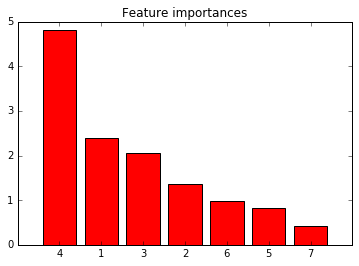


Random Forest Classification:
[ 0.57894737  0.63157895  0.57894737  0.52941176  0.52941176]
Accuracy: 0.57 (+/- 0.08)
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.232141)
2. feature 5 - 28A Case Syncretism (0.173557)
3. feature 4 - 27A Reduplication (0.165307)
4. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.127479)
5. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.111416)
6. feature 0 - 23A Locus of Marking in the Clause (0.101205)
7. feature 2 - 25A Locus of Marking: Whole-language Typology (0.088896)


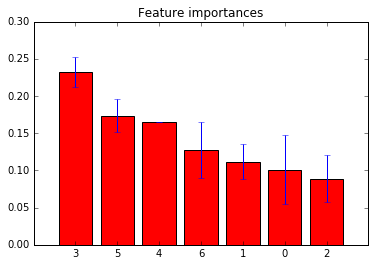


Extra Trees Classification:
[ 0.57894737  0.63157895  0.57894737  0.47058824  0.58823529]
Accuracy: 0.57 (+/- 0.11)
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.209077)
2. feature 5 - 28A Case Syncretism (0.193936)
3. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.144973)
4. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.139879)
5. feature 4 - 27A Reduplication (0.107950)
6. feature 0 - 23A Locus of Marking in the Clause (0.107351)
7. feature 2 - 25A Locus of Marking: Whole-language Typology (0.096833)


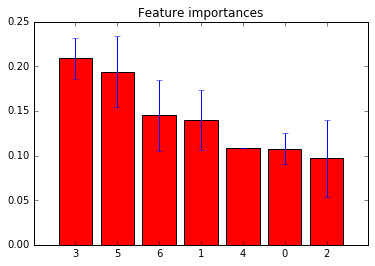

In [212]:
#Arid,Cold,Polar(N) vs Tropical,Temperate(O)

y_ = lb.inverse_transform(P)
for l in range(0,len(y_)):
    if y_[l]=='A' or y_[l]=='C':
        y_[l] = 'O'
    else:
        y_[l] = 'N'
        
class_grouped(F,y_,ft)




Dummy Classifier
0.54043956044
Linear SVM Classification C-V:
[ 0.42105263  0.52631579  0.52631579  0.41176471  0.64705882]
Accuracy: 0.51 (+/- 0.17)
Linear SVM Feature Importance:
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (4.813241)
2. feature 0 - 23A Locus of Marking in the Clause (2.402186)
3. feature 2 - 25A Locus of Marking: Whole-language Typology (2.055639)
4. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (1.359049)
5. feature 5 - 28A Case Syncretism (0.971786)
6. feature 4 - 27A Reduplication (0.821636)
7. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.422123)


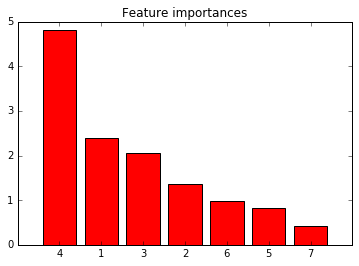


Random Forest Classification:
[ 0.68421053  0.52631579  0.73684211  0.52941176  0.58823529]
Accuracy: 0.61 (+/- 0.17)
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.267149)
2. feature 5 - 28A Case Syncretism (0.156624)
3. feature 0 - 23A Locus of Marking in the Clause (0.135696)
4. feature 4 - 27A Reduplication (0.131695)
5. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.115985)
6. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.109128)
7. feature 2 - 25A Locus of Marking: Whole-language Typology (0.083724)


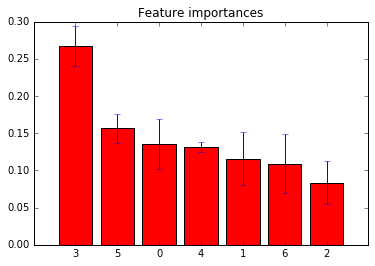


Extra Trees Classification:
[ 0.63157895  0.63157895  0.57894737  0.52941176  0.52941176]
Accuracy: 0.58 (+/- 0.09)
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.235802)
2. feature 5 - 28A Case Syncretism (0.182055)
3. feature 4 - 27A Reduplication (0.145634)
4. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.122305)
5. feature 0 - 23A Locus of Marking in the Clause (0.107075)
6. feature 2 - 25A Locus of Marking: Whole-language Typology (0.105021)
7. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.102110)


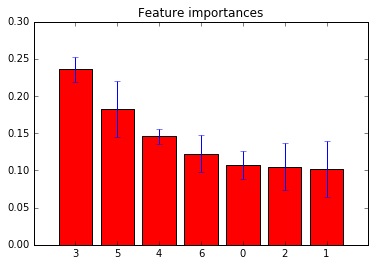

In [213]:
#Arid,Cold,Polar(P) vs Tropical,Temperate(Q)

y_ = lb.inverse_transform(P)
for l in range(0,len(y_)):
    if y_[l]=='A' or y_[l]=='C':
        y_[l] = 'P'
    else:
        y_[l] = 'Q'
        
class_grouped(F,y_,ft)

Dummy Classifier
0.496901098901
Linear SVM Classification C-V:
[ 0.42105263  0.63157895  0.33333333  0.55555556  0.64705882]
Accuracy: 0.52 (+/- 0.24)
Linear SVM Feature Importance:
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (3.863987)
2. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (2.476073)
3. feature 2 - 25A Locus of Marking: Whole-language Typology (1.941190)
4. feature 0 - 23A Locus of Marking in the Clause (1.662802)
5. feature 6 - 29A Syncretism in Verbal Person/Number Marking (1.618349)
6. feature 5 - 28A Case Syncretism (1.374078)
7. feature 4 - 27A Reduplication (1.136769)


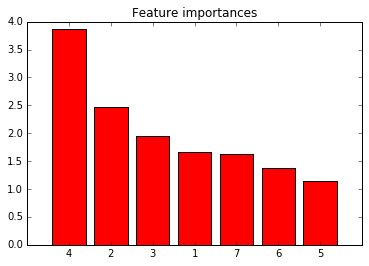


Random Forest Classification:
[ 0.63157895  0.68421053  0.5         0.5         0.52941176]
Accuracy: 0.57 (+/- 0.15)
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.178687)
2. feature 5 - 28A Case Syncretism (0.152188)
3. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.150048)
4. feature 0 - 23A Locus of Marking in the Clause (0.141850)
5. feature 2 - 25A Locus of Marking: Whole-language Typology (0.139552)
6. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.134624)
7. feature 4 - 27A Reduplication (0.103051)


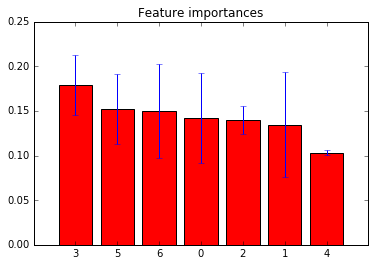


Extra Trees Classification:
[ 0.63157895  0.63157895  0.66666667  0.38888889  0.64705882]
Accuracy: 0.59 (+/- 0.21)
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.219910)
2. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.148280)
3. feature 5 - 28A Case Syncretism (0.139756)
4. feature 4 - 27A Reduplication (0.132136)
5. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.120346)
6. feature 0 - 23A Locus of Marking in the Clause (0.120196)
7. feature 2 - 25A Locus of Marking: Whole-language Typology (0.119374)


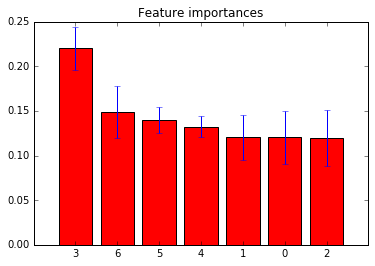

In [215]:
#Arid,Temperate(R) vs Tropical,Cold,Polar(S)
y_ = lb.inverse_transform(P)
for l in range(0,len(y_)):
    if y_[l]=='B' or y_[l]=='C':
        y_[l] = 'R'
    else:
        y_[l] = 'S'
        
class_grouped(F,y_,ft)

Dummy Classifier
0.564857142857
Linear SVM Classification C-V:
[ 0.63157895  0.78947368  0.55555556  0.77777778  0.64705882]
Accuracy: 0.68 (+/- 0.18)
Linear SVM Feature Importance:
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (2.887985)
2. feature 0 - 23A Locus of Marking in the Clause (2.655887)
3. feature 5 - 28A Case Syncretism (2.380553)
4. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (1.761257)
5. feature 6 - 29A Syncretism in Verbal Person/Number Marking (1.626103)
6. feature 2 - 25A Locus of Marking: Whole-language Typology (1.405832)
7. feature 4 - 27A Reduplication (1.333408)


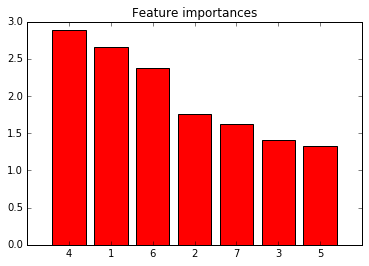


Random Forest Classification:
[ 0.63157895  0.78947368  0.66666667  0.72222222  0.76470588]
Accuracy: 0.71 (+/- 0.12)
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.221892)
2. feature 0 - 23A Locus of Marking in the Clause (0.196625)
3. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.127859)
4. feature 4 - 27A Reduplication (0.126853)
5. feature 2 - 25A Locus of Marking: Whole-language Typology (0.120149)
6. feature 5 - 28A Case Syncretism (0.117596)
7. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.089025)


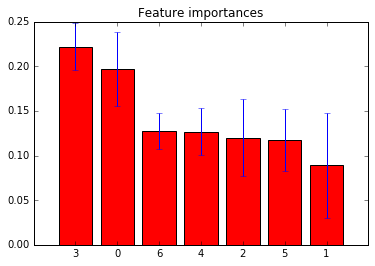


Extra Trees Classification:
[ 0.63157895  0.73684211  0.66666667  0.77777778  0.64705882]
Accuracy: 0.69 (+/- 0.11)
Feature ranking:
1. feature 3 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.307318)
2. feature 0 - 23A Locus of Marking in the Clause (0.152893)
3. feature 4 - 27A Reduplication (0.119634)
4. feature 1 - 24A Locus of Marking in Possessive Noun Phrases (0.118163)
5. feature 5 - 28A Case Syncretism (0.110889)
6. feature 6 - 29A Syncretism in Verbal Person/Number Marking (0.102863)
7. feature 2 - 25A Locus of Marking: Whole-language Typology (0.088240)


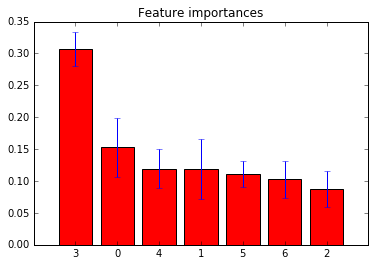

In [216]:
#Tropical(T) vs Temperate,Cold,Polar(U)
y_ = lb.inverse_transform(P)
for l in range(0,len(y_)):
    if y_[l]=='A':
        y_[l] = 'T'
    else:
        y_[l] = 'U'
        
class_grouped(F,y_,ft)



In [ ]:
#Determine Features with highest languages from 8-10 subsets
A =['26A Prefixing vs. Suffixing in Inflectional Morphology','6A Uvular Consonants','7A Glottalized Consonants' ]
for i in range(0, len(lis)):
    if  i == len(lis)-1:
        
        


In [337]:
#MIXED FEATURES - PHONOLOGY AND MORPHOLOGY Classification -PREPROCCESSING AND STATISTICS
#26A Prefixing vs. Suffixing in Inflectional Morphology 
df3 = lang_df[lang_df['26A Prefixing vs. Suffixing in Inflectional Morphology'].notnull() & lang_df['6A Uvular Consonants'].notnull() 
              & lang_df['7A Glottalized Consonants'].notnull() & lang_df['4A Voicing in Plosives and Fricatives'].notnull() 
              & lang_df['11A Front Rounded Vowels'].notnull() & lang_df['19A Presence of Uncommon Consonants'].notnull()
              & lang_df['8A Lateral Consonants'].notnull() & lang_df['28A Case Syncretism'].notnull()
              & lang_df['29A Syncretism in Verbal Person/Number Marking'].notnull()]

#6A,7A,26A
fts = ['26A Prefixing vs. Suffixing in Inflectional Morphology','6A Uvular Consonants',
       '7A Glottalized Consonants','4A Voicing in Plosives and Fricatives', '11A Front Rounded Vowels','19A Presence of Uncommon Consonants',
       '8A Lateral Consonants','28A Case Syncretism', '29A Syncretism in Verbal Person/Number Marking']
#pre-proccesing
#F,P = df_list(df2,ft)
Cl= pd.Series.tolist(df3['Climate'])
stats_out(Cl)
print(len(Cl))

df3






A - Tropical: 54
B - Arid: 30
C - Temperate: 47
D - Cold: 16
E - Polar: 5
152


,wals_code,iso_code,glottocode,Name,latitude,longitude,genus,family,macroarea,countrycodes,...,136B M in First Person Singular,109B Other Roles of Applied Objects,10B Nasal Vowels in West Africa,25B Zero Marking of A and P Arguments,21B Exponence of Tense-Aspect-Mood Inflection,108B Productivity of the Antipassive Construction,130B Cultural Categories of Languages with Identity of 'Finger' and 'Hand',58B Number of Possessive Nouns,79B Suppletion in Imperatives and Hortatives,Climate
7,abi,axb,abip1241,AbipÌ_n,-29.000000,-61.000000,South Guaicuruan,Guaicuruan,South America,AR,...,NaN,NaN,NaN,NaN,1 monoexponential TAM,NaN,NaN,NaN,NaN,C
8,abk,abk,abkh1244,Abkhaz,43.083333,41.000000,Northwest Caucasian,Northwest Caucasian,Eurasia,GE,...,1 No m in first person singular,1 Instrument,NaN,2 Non-zero marking,1 monoexponential TAM,4 no antipassive,NaN,1 None reported,5 None (= no suppletive imperatives reported i...,D
23,aco,kjq,west2632,Acoma,34.916667,-107.583333,Keresan,Keresan,North America,US,...,1 No m in first person singular,4 No other roles (= Only benefactive),NaN,2 Non-zero marking,2 TAM+agreement,NaN,NaN,1 None reported,3 Hortative,B
34,aeg,arz,egyp1253,Arabic (Egyptian),30.000000,31.000000,Semitic,Afro-Asiatic,Africa,EG,...,1 No m in first person singular,5 No applicative construction,NaN,2 Non-zero marking,3 TAM+agreement+diathesis,4 no antipassive,NaN,1 None reported,2 Imperative,B
54,ain,ain,ainu1240,Ainu,43.000000,143.000000,Ainu,Ainu,Eurasia,JP,...,1 No m in first person singular,3 Instrument and locative,NaN,2 Non-zero marking,NaN,4 no antipassive,NaN,1 None reported,5 None (= no suppletive imperatives reported i...,D
70,ala,amp,alam1246,Alamblak,-4.666667,143.333333,Sepik Hill,Sepik,Papunesia,PG,...,1 No m in first person singular,4 No other roles (= Only benefactive),NaN,2 Non-zero marking,1 monoexponential TAM,4 no antipassive,NaN,1 None reported,5 None (= no suppletive imperatives reported i...,A
105,ana,aro,arao1248,Araona,-12.333333,-67.750000,Tacanan,Tacanan,South America,BO,...,NaN,NaN,NaN,NaN,1 monoexponential TAM,NaN,NaN,NaN,5 None (= no suppletive imperatives reported i...,A
128,apu,apu,apur1254,ApurinÌ£,-9.000000,-67.000000,Purus,Arawakan,South America,BR,...,1 No m in first person singular,5 No applicative construction,NaN,2 Non-zero marking,1 monoexponential TAM,4 no antipassive,NaN,1 None reported,5 None (= no suppletive imperatives reported i...,A
140,arm,hye,nucl1235,Armenian (Eastern),40.000000,45.000000,Armenian,Indo-European,Eurasia,AM,...,NaN,5 No applicative construction,NaN,NaN,NaN,4 no antipassive,NaN,1 None reported,2 Imperative,D
153,asm,tml,tamn1235,Asmat,-5.500000,138.500000,Asmat-Kamoro,Trans-New Guinea,Papunesia,ID,...,1 No m in first person singular,4 No other roles (= Only benefactive),NaN,2 Non-zero marking,1 monoexponential TAM,4 no antipassive,NaN,1 None reported,5 None (= no suppletive imperatives reported i...,A


In [338]:
lab = LabelBinarizer()
X, Y = df_list(fts, df3)
enco = OneHotEncoder()
X = enco.fit_transform(X).toarray()
lab.fit(Y)
Y = lab.transform(Y)

In [339]:
sv_and_dummy(X,Y)

C-V scores, SV Method 1  - OHE : 
[ 0.09677419  0.25806452  0.16666667  0.13333333  0.16666667]
C-V scores, SV Method 1  - non-OHE : 
[ 0.12903226  0.32258065  0.13333333  0.13333333  0.16666667]
C-V scores, Dummy Classifier:
0.274894736842
Accuracy for C-V (95 CI) , Method 1  - OHE : 0.16 (+/- 0.11)
Accuracy for C-V (95 CI), Method 2  - OHE : 0.18 (+/- 0.15)


In [335]:
sv_ovr = OneVsRestClassifier(LinearSVC(random_state=0, class_weight='balanced'))

Coefficients for One vs Rest SVM:

 Feature ranking:
1. feature 6 - 19A Presence of Uncommon Consonants (0.254739)
2. feature 3 - 7A Glottalized Consonants (0.152340)
3. feature 5 - 11A Front Rounded Vowels (0.127399)
4. feature 7 - 8A Lateral Consonants (0.120618)
5. feature 1 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.113116)
6. feature 2 - 6A Uvular Consonants (0.106444)
7. feature 4 - 4A Voicing in Plosives and Fricatives (0.049298)
8. feature 8 - 28A Case Syncretism (0.047332)
9. feature 9 - 29A Syncretism in Verbal Person/Number Marking (0.028715)


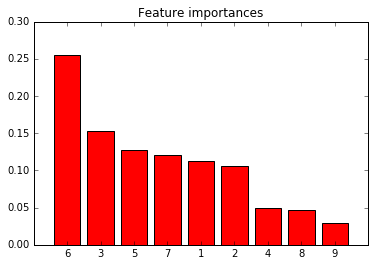

In [340]:
sv_ovr.fit(X, Y)
coef = sv_ovr.coef_


print("Coefficients for One vs Rest SVM:")

a = np.absolute(coef)
b = np.sum(a, axis=0)
b = np.square(b)
s = sum(b)
feat = np.true_divide(b,s)
feat = np.asarray(feat)
feat = feat.tolist()

feat = feat_imp_ohe(enco.feature_indices_, enco.active_features_, feat)

ind = np.argsort(feat)[::-1]

print("\n Feature ranking:")

X = np.asarray(X)

for f in range(len(feat)):
    print("%d. feature %d - %s (%f)" % (f + 1, ind[f] + 1, fts[ind[f]], feat[ind[f]]))
    
feat = np.asarray(feat)
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(feat)), feat[ind],
       color="r", align="center")
plt.xticks(range(len(feat)), ind+1)
plt.xlim([-1, len(feat)])
plt.show()

In [320]:
train_x, test_x, train_y, test_y = train_test_split(X, Y)
rfc.fit(X, Y)

trained_model = rfc.fit(train_x, train_y)
trained_model

predictions = trained_model.predict(test_x)
test_y = lab.inverse_transform(test_y)
predictions = lb.inverse_transform(predictions)
print("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print("Test Accuracy  :: ", accuracy_score(test_y, predictions))

#Cross validation for RF 95% Confidence Interval
scores = cross_val_score(rfc, X, Y, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Confusion matrix for tested sample
y_actu = pd.Series(test_y, name='Actual')
y_pred = pd.Series(predictions, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion


Train Accuracy ::  0.824561403509
Test Accuracy  ::  0.473684210526
[ 0.25806452  0.38709677  0.2         0.33333333  0.2       ]
Accuracy: 0.28 (+/- 0.15)


Predicted,A,B,C,D
Actual,,,,
A,12,0,0,0
B,3,0,0,0
C,11,0,5,1
D,2,0,1,1
E,1,1,0,0


[0.13362729900188017, 0.09101509002278223, 0.12094428292415965, 0.14212398346861316, 0.11242003262480867, 0.03768985294639352, 0.10246824313927183, 0.042895396820622586, 0.12188896972485776, 0.09492684932661041]
Feature ranking:
[0 3 6 7 1 8 2 5 4]
['26A Prefixing vs. Suffixing in Inflectional Morphology', '6A Uvular Consonants', '7A Glottalized Consonants', '4A Voicing in Plosives and Fricatives', '11A Front Rounded Vowels', '19A Presence of Uncommon Consonants', '8A Lateral Consonants', '28A Case Syncretism', '29A Syncretism in Verbal Person/Number Marking']
[0.166491514229761, 0.115773006443109, 0.10105229909651509, 0.1470784673387197, 0.029180239418139554, 0.08261869430342611, 0.1297944717867879, 0.12110733776045449, 0.10690396962308711]
1. feature 1 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.166492)
2. feature 4 - 4A Voicing in Plosives and Fricatives (0.147078)
3. feature 7 - 8A Lateral Consonants (0.129794)
4. feature 8 - 28A Case Syncretism (0.121107)
5. featur

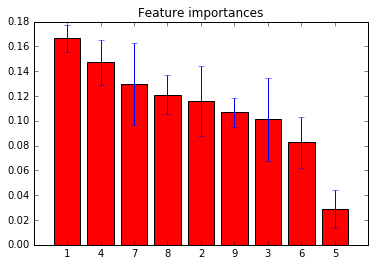

In [321]:
#Feature Importance
print(importances)
importances = trained_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in trained_model.estimators_],
             axis=0)

importances = importances.tolist()

# Print the feature ranking
print("Feature ranking:")

importances = feat_imp_ohe(enco.feature_indices_, enco.active_features_, importances)

indices = np.argsort(importances)[::-1]

print(indices)
print(fts)
print(importances)

for f in range(0,len(fts)):
    print("%d. feature %d - %s (%f)" % ( f + 1 , indices[f] + 1, fts[indices[f]], importances[indices[f]]))
    
importances = np.asarray(importances)

plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(importances)), (indices+1))
plt.xlim([-1, len(importances)])
plt.show()


TROPICAL AND ARID - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.538071428571

 Linear SVM Classification C-V:
Accuracy: 0.57 (+/- 0.11)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (3.836734)
2. feature 5 - 19A Presence of Uncommon Consonants (2.999263)
3. feature 2 - 7A Glottalized Consonants (2.800000)
4. feature 6 - 8A Lateral Consonants (2.227569)
5. feature 1 - 6A Uvular Consonants (2.000346)
6. feature 7 - 28A Case Syncretism (1.632819)
7. feature 3 - 4A Voicing in Plosives and Fricatives (0.894316)
8. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.499897)
9. feature 4 - 11A Front Rounded Vowels (0.000000)


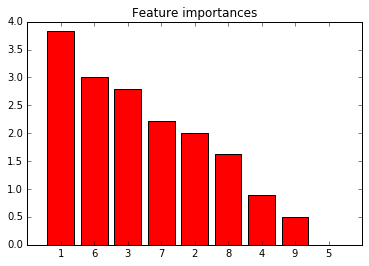



 Random Forest Classification C-V: 

Accuracy: 0.70 (+/- 0.20)
Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.246201)
2. feature 7 - 28A Case Syncretism (0.144382)
3. feature 3 - 4A Voicing in Plosives and Fricatives (0.138034)
4. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.114667)
5. feature 2 - 7A Glottalized Consonants (0.108250)
6. feature 5 - 19A Presence of Uncommon Consonants (0.092058)
7. feature 6 - 8A Lateral Consonants (0.091264)
8. feature 1 - 6A Uvular Consonants (0.065143)
9. feature 4 - 11A Front Rounded Vowels (0.000000)


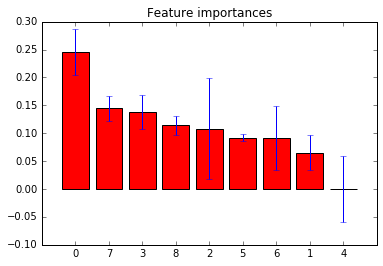


Extra Trees Classification: 

[ 0.76470588  0.58823529  0.76470588  0.82352941  0.75      ]
Accuracy: 0.74 (+/- 0.16)

Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.247554)
2. feature 7 - 28A Case Syncretism (0.143629)
3. feature 3 - 4A Voicing in Plosives and Fricatives (0.127483)
4. feature 6 - 8A Lateral Consonants (0.117853)
5. feature 1 - 6A Uvular Consonants (0.108416)
6. feature 5 - 19A Presence of Uncommon Consonants (0.096964)
7. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.096165)
8. feature 2 - 7A Glottalized Consonants (0.061936)
9. feature 4 - 11A Front Rounded Vowels (0.000000)


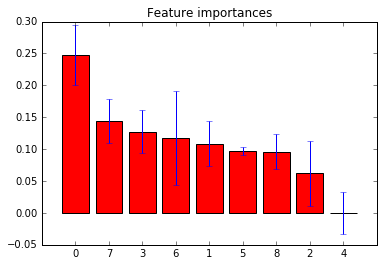


PERMUTATION TEST: 

Linear SVM - Classification score 0.618181818182 (pvalue : 0.108910891089 )

Random Forest - Classification score 0.679545454545 (pvalue : 0.049504950495)

TROPICAL AND TEMPERATE - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.503287128713

 Linear SVM Classification C-V:
Accuracy: 0.67 (+/- 0.09)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 2 - 7A Glottalized Consonants (4.470839)
2. feature 1 - 6A Uvular Consonants (2.774662)
3. feature 6 - 8A Lateral Consonants (2.666684)
4. feature 4 - 11A Front Rounded Vowels (2.171599)
5. feature 5 - 19A Presence of Uncommon Consonants (1.870370)
6. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (1.611925)
7. feature 8 - 29A Syncretism in Verbal Person/Number Marking (1.384037)
8. feature 3 - 4A Voicing in Plosives and Fricatives (1.020436)
9. feature 7 - 28A Case Syncretism (0.753674)


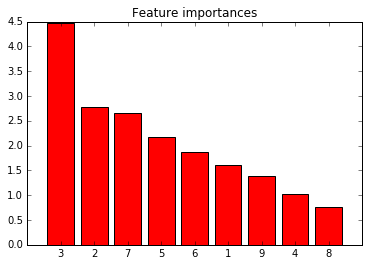



 Random Forest Classification C-V: 

Accuracy: 0.66 (+/- 0.17)
Feature ranking:
1. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.137173)
2. feature 6 - 8A Lateral Consonants (0.135620)
3. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.132089)
4. feature 3 - 4A Voicing in Plosives and Fricatives (0.129617)
5. feature 1 - 6A Uvular Consonants (0.121704)
6. feature 2 - 7A Glottalized Consonants (0.100934)
7. feature 7 - 28A Case Syncretism (0.089229)
8. feature 4 - 11A Front Rounded Vowels (0.077042)
9. feature 5 - 19A Presence of Uncommon Consonants (0.076591)


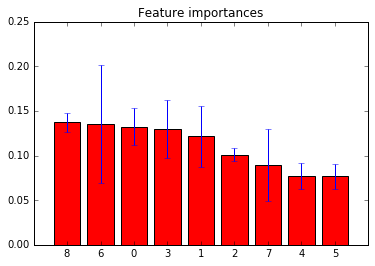


Extra Trees Classification: 

[ 0.57142857  0.80952381  0.6         0.6         0.68421053]
Accuracy: 0.65 (+/- 0.17)

Feature ranking:
1. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.142154)
2. feature 6 - 8A Lateral Consonants (0.141065)
3. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.131850)
4. feature 3 - 4A Voicing in Plosives and Fricatives (0.131257)
5. feature 2 - 7A Glottalized Consonants (0.124449)
6. feature 1 - 6A Uvular Consonants (0.101606)
7. feature 7 - 28A Case Syncretism (0.100254)
8. feature 5 - 19A Presence of Uncommon Consonants (0.083354)
9. feature 4 - 11A Front Rounded Vowels (0.044012)


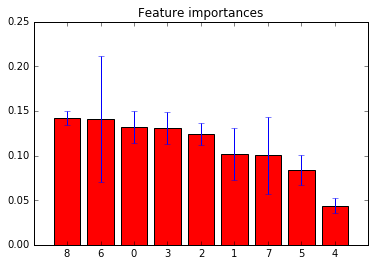


PERMUTATION TEST: 

Linear SVM - Classification score 0.662852564103 (pvalue : 0.019801980198 )

Random Forest - Classification score 0.642435897436 (pvalue : 0.00990099009901)

TROPICAL AND COLD - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.645114285714

 Linear SVM Classification C-V:
Accuracy: 0.73 (+/- 0.16)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 2 - 7A Glottalized Consonants (2.859383)
2. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (2.448681)
3. feature 1 - 6A Uvular Consonants (2.199410)
4. feature 7 - 28A Case Syncretism (1.733909)
5. feature 8 - 29A Syncretism in Verbal Person/Number Marking (1.366465)
6. feature 4 - 11A Front Rounded Vowels (1.289605)
7. feature 3 - 4A Voicing in Plosives and Fricatives (1.284624)
8. feature 5 - 19A Presence of Uncommon Consonants (1.053088)
9. feature 6 - 8A Lateral Consonants (0.300825)


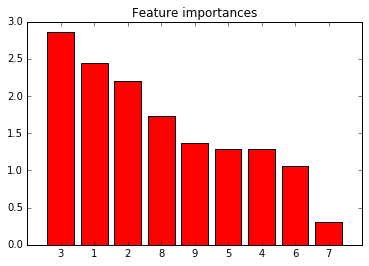



 Random Forest Classification C-V: 

Accuracy: 0.82 (+/- 0.13)
Feature ranking:
1. feature 1 - 6A Uvular Consonants (0.298256)
2. feature 2 - 7A Glottalized Consonants (0.166746)
3. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.142714)
4. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.103681)
5. feature 7 - 28A Case Syncretism (0.072729)
6. feature 6 - 8A Lateral Consonants (0.068569)
7. feature 3 - 4A Voicing in Plosives and Fricatives (0.067936)
8. feature 4 - 11A Front Rounded Vowels (0.060955)
9. feature 5 - 19A Presence of Uncommon Consonants (0.018414)


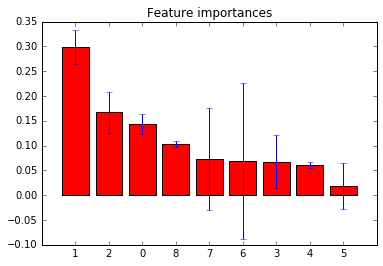


Extra Trees Classification: 

[ 0.73333333  0.85714286  0.78571429  0.92857143  0.84615385]
Accuracy: 0.83 (+/- 0.13)

Feature ranking:
1. feature 2 - 7A Glottalized Consonants (0.164796)
2. feature 7 - 28A Case Syncretism (0.162099)
3. feature 1 - 6A Uvular Consonants (0.148463)
4. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.133265)
5. feature 4 - 11A Front Rounded Vowels (0.100702)
6. feature 3 - 4A Voicing in Plosives and Fricatives (0.097781)
7. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.084682)
8. feature 6 - 8A Lateral Consonants (0.078703)
9. feature 5 - 19A Presence of Uncommon Consonants (0.029509)


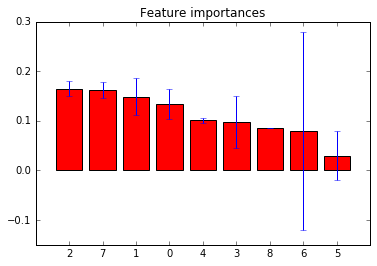


PERMUTATION TEST: 

Linear SVM - Classification score 0.725490196078 (pvalue : 0.029702970297 )

Random Forest - Classification score 0.78431372549 (pvalue : 0.019801980198)

ARID AND TEMPERATE - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.522545454545

 Linear SVM Classification C-V:
Accuracy: 0.54 (+/- 0.07)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (4.690539)
2. feature 5 - 19A Presence of Uncommon Consonants (2.415137)
3. feature 4 - 11A Front Rounded Vowels (2.327593)
4. feature 6 - 8A Lateral Consonants (2.056943)
5. feature 2 - 7A Glottalized Consonants (2.027406)
6. feature 7 - 28A Case Syncretism (1.835385)
7. feature 3 - 4A Voicing in Plosives and Fricatives (1.296182)
8. feature 1 - 6A Uvular Consonants (1.081872)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.433538)


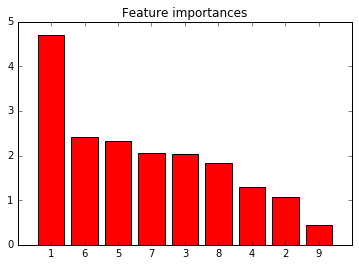



 Random Forest Classification C-V: 

Accuracy: 0.62 (+/- 0.07)
Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.241378)
2. feature 7 - 28A Case Syncretism (0.149617)
3. feature 3 - 4A Voicing in Plosives and Fricatives (0.144287)
4. feature 6 - 8A Lateral Consonants (0.137852)
5. feature 5 - 19A Presence of Uncommon Consonants (0.096297)
6. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.069998)
7. feature 2 - 7A Glottalized Consonants (0.062137)
8. feature 1 - 6A Uvular Consonants (0.052115)
9. feature 4 - 11A Front Rounded Vowels (0.046319)


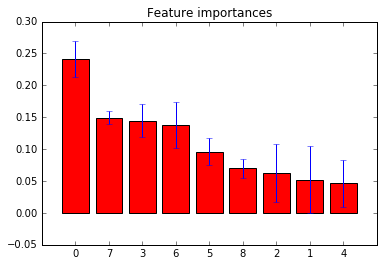


Extra Trees Classification: 

[ 0.5         0.625       0.6         0.6         0.26666667]
Accuracy: 0.52 (+/- 0.27)

Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.212935)
2. feature 3 - 4A Voicing in Plosives and Fricatives (0.159593)
3. feature 6 - 8A Lateral Consonants (0.141793)
4. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.129040)
5. feature 7 - 28A Case Syncretism (0.108533)
6. feature 2 - 7A Glottalized Consonants (0.078437)
7. feature 5 - 19A Presence of Uncommon Consonants (0.061576)
8. feature 1 - 6A Uvular Consonants (0.054416)
9. feature 4 - 11A Front Rounded Vowels (0.053677)


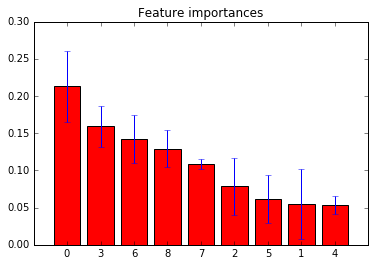


PERMUTATION TEST: 

Linear SVM - Classification score 0.556578947368 (pvalue : 0.267326732673 )

Random Forest - Classification score 0.557236842105 (pvalue : 0.326732673267)

ARID AND COLD - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.542217391304

 Linear SVM Classification C-V:
Accuracy: 0.54 (+/- 0.35)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 5 - 19A Presence of Uncommon Consonants (2.788659)
2. feature 6 - 8A Lateral Consonants (2.114674)
3. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (1.884979)
4. feature 3 - 4A Voicing in Plosives and Fricatives (1.791090)
5. feature 4 - 11A Front Rounded Vowels (1.669044)
6. feature 2 - 7A Glottalized Consonants (1.587692)
7. feature 7 - 28A Case Syncretism (1.203757)
8. feature 1 - 6A Uvular Consonants (0.797094)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.673855)


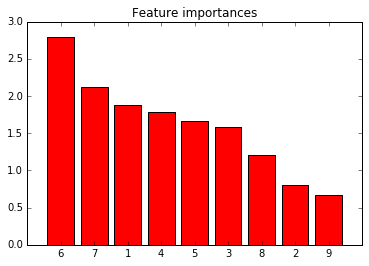



 Random Forest Classification C-V: 

Accuracy: 0.70 (+/- 0.26)
Feature ranking:
1. feature 2 - 7A Glottalized Consonants (0.169416)
2. feature 7 - 28A Case Syncretism (0.156243)
3. feature 3 - 4A Voicing in Plosives and Fricatives (0.145657)
4. feature 1 - 6A Uvular Consonants (0.111742)
5. feature 4 - 11A Front Rounded Vowels (0.110437)
6. feature 6 - 8A Lateral Consonants (0.096232)
7. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.091699)
8. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.079125)
9. feature 5 - 19A Presence of Uncommon Consonants (0.039449)


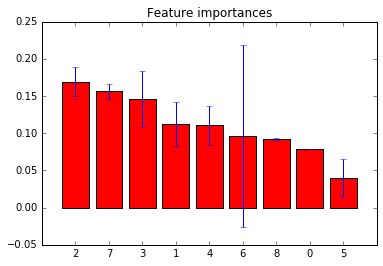


Extra Trees Classification: 

[ 0.3         0.66666667  0.77777778  0.66666667  0.66666667]
Accuracy: 0.62 (+/- 0.33)

Feature ranking:
1. feature 1 - 6A Uvular Consonants (0.174436)
2. feature 2 - 7A Glottalized Consonants (0.130514)
3. feature 3 - 4A Voicing in Plosives and Fricatives (0.130050)
4. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.122549)
5. feature 7 - 28A Case Syncretism (0.108482)
6. feature 4 - 11A Front Rounded Vowels (0.106433)
7. feature 6 - 8A Lateral Consonants (0.094358)
8. feature 5 - 19A Presence of Uncommon Consonants (0.075293)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.057885)


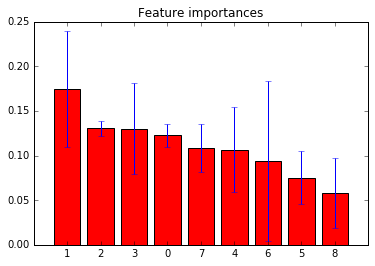


PERMUTATION TEST: 

Linear SVM - Classification score 0.589015151515 (pvalue : 0.227722772277 )

Random Forest - Classification score 0.518939393939 (pvalue : 0.821782178218)

TEMPERATE AND COLD - BINARY CLASSIFICATION
Dummy Classifier Average Score:
0.621936507937

 Linear SVM Classification C-V:
Accuracy: 0.51 (+/- 0.22)
Linear SVM Feature Importance: 

Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (2.313964)
2. feature 1 - 6A Uvular Consonants (2.188953)
3. feature 3 - 4A Voicing in Plosives and Fricatives (2.170951)
4. feature 7 - 28A Case Syncretism (2.071673)
5. feature 6 - 8A Lateral Consonants (1.959380)
6. feature 8 - 29A Syncretism in Verbal Person/Number Marking (1.828631)
7. feature 4 - 11A Front Rounded Vowels (1.822980)
8. feature 5 - 19A Presence of Uncommon Consonants (1.483923)
9. feature 2 - 7A Glottalized Consonants (1.038001)


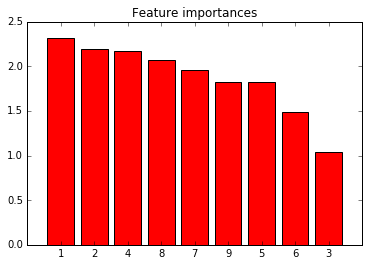



 Random Forest Classification C-V: 

Accuracy: 0.68 (+/- 0.20)
Feature ranking:
1. feature 7 - 28A Case Syncretism (0.188663)
2. feature 1 - 6A Uvular Consonants (0.161909)
3. feature 2 - 7A Glottalized Consonants (0.123299)
4. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.120632)
5. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.112294)
6. feature 3 - 4A Voicing in Plosives and Fricatives (0.108080)
7. feature 6 - 8A Lateral Consonants (0.091354)
8. feature 5 - 19A Presence of Uncommon Consonants (0.061357)
9. feature 4 - 11A Front Rounded Vowels (0.032412)


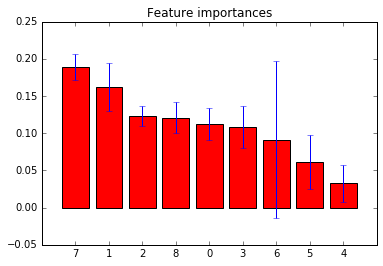


Extra Trees Classification: 

[ 0.71428571  0.53846154  0.75        0.58333333  0.41666667]
Accuracy: 0.60 (+/- 0.24)

Feature ranking:
1. feature 1 - 6A Uvular Consonants (0.189887)
2. feature 7 - 28A Case Syncretism (0.167769)
3. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.136385)
4. feature 3 - 4A Voicing in Plosives and Fricatives (0.124328)
5. feature 2 - 7A Glottalized Consonants (0.119374)
6. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.080502)
7. feature 6 - 8A Lateral Consonants (0.077977)
8. feature 4 - 11A Front Rounded Vowels (0.053527)
9. feature 5 - 19A Presence of Uncommon Consonants (0.050252)


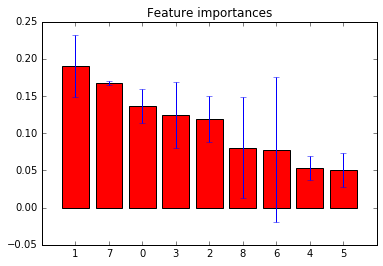


PERMUTATION TEST: 

Linear SVM - Classification score 0.473958333333 (pvalue : 0.891089108911 )

Random Forest - Classification score 0.583333333333 (pvalue : 0.980198019802)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [282]:
#Binary One vs One
binary_clas(df3, fts, sub)

Dummy Classifier
0.563174447174
Linear SVM Classification C-V:
[ 0.6626506   0.61728395  0.67901235  0.67901235  0.71604938]
Accuracy: 0.67 (+/- 0.06)
Linear SVM Feature Importance:
Feature ranking:
1. feature 1 - 6A Uvular Consonants (3.825478)
2. feature 3 - 4A Voicing in Plosives and Fricatives (2.060111)
3. feature 5 - 19A Presence of Uncommon Consonants (1.976993)
4. feature 4 - 11A Front Rounded Vowels (1.765349)
5. feature 6 - 8A Lateral Consonants (1.388293)
6. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (1.343319)
7. feature 7 - 28A Case Syncretism (1.297800)
8. feature 2 - 7A Glottalized Consonants (0.756256)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.745672)


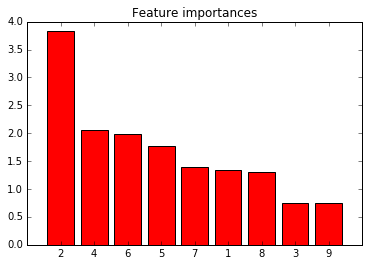


Random Forest Classification:
[ 0.72289157  0.67901235  0.7037037   0.74074074  0.72839506]
Accuracy: 0.71 (+/- 0.04)
Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.158157)
2. feature 2 - 7A Glottalized Consonants (0.135912)
3. feature 1 - 6A Uvular Consonants (0.122711)
4. feature 6 - 8A Lateral Consonants (0.085083)
5. feature 5 - 19A Presence of Uncommon Consonants (0.075237)
6. feature 7 - 28A Case Syncretism (0.066903)
7. feature 3 - 4A Voicing in Plosives and Fricatives (0.060249)
8. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.048859)
9. feature 4 - 11A Front Rounded Vowels (0.048139)


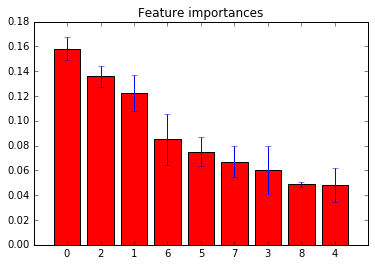


Extra Trees Classification:
[ 0.72289157  0.69135802  0.71604938  0.72839506  0.75308642]
Accuracy: 0.72 (+/- 0.04)
Feature ranking:
1. feature 2 - 7A Glottalized Consonants (0.179124)
2. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.145013)
3. feature 1 - 6A Uvular Consonants (0.098283)
4. feature 6 - 8A Lateral Consonants (0.098142)
5. feature 5 - 19A Presence of Uncommon Consonants (0.062772)
6. feature 4 - 11A Front Rounded Vowels (0.058786)
7. feature 7 - 28A Case Syncretism (0.053099)
8. feature 3 - 4A Voicing in Plosives and Fricatives (0.050612)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.027045)


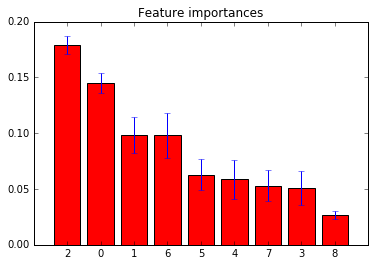

In [283]:
#BINARY GROUP CLASSIFICATION

#Arid,Cold,Polar(H) vs Tropical,Temperate(I)

y_ = lb.inverse_transform(Y)
for l in range(0,len(y_)):
    if y_[l]=='A' or y_[l]=='C':
        y_[l] = 'H'
    else:
        y_[l] = 'I'
class_grouped(X,y_,fts)

Dummy Classifier
0.525395577396
Linear SVM Classification C-V:
[ 0.64634146  0.80487805  0.7037037   0.69135802  0.71604938]
Accuracy: 0.71 (+/- 0.10)
Linear SVM Feature Importance:
Feature ranking:
1. feature 1 - 6A Uvular Consonants (2.663925)
2. feature 7 - 28A Case Syncretism (2.319019)
3. feature 4 - 11A Front Rounded Vowels (2.240332)
4. feature 3 - 4A Voicing in Plosives and Fricatives (1.908474)
5. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (1.761582)
6. feature 5 - 19A Presence of Uncommon Consonants (1.563868)
7. feature 2 - 7A Glottalized Consonants (1.100678)
8. feature 8 - 29A Syncretism in Verbal Person/Number Marking (1.048959)
9. feature 6 - 8A Lateral Consonants (0.413975)


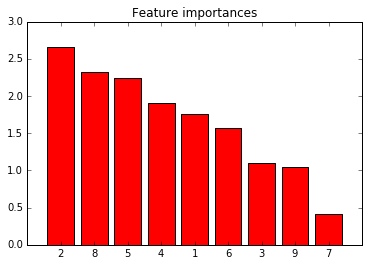


Random Forest Classification:
[ 0.68292683  0.80487805  0.67901235  0.67901235  0.7654321 ]
Accuracy: 0.72 (+/- 0.11)
Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.161911)
2. feature 2 - 7A Glottalized Consonants (0.124125)
3. feature 1 - 6A Uvular Consonants (0.114182)
4. feature 6 - 8A Lateral Consonants (0.113273)
5. feature 5 - 19A Presence of Uncommon Consonants (0.093392)
6. feature 4 - 11A Front Rounded Vowels (0.079885)
7. feature 7 - 28A Case Syncretism (0.060749)
8. feature 3 - 4A Voicing in Plosives and Fricatives (0.054347)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.036027)


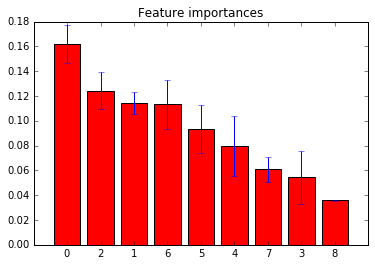


Extra Trees Classification:
[ 0.69512195  0.84146341  0.60493827  0.69135802  0.72839506]
Accuracy: 0.71 (+/- 0.15)
Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.194583)
2. feature 2 - 7A Glottalized Consonants (0.193424)
3. feature 5 - 19A Presence of Uncommon Consonants (0.091540)
4. feature 6 - 8A Lateral Consonants (0.085182)
5. feature 1 - 6A Uvular Consonants (0.082840)
6. feature 3 - 4A Voicing in Plosives and Fricatives (0.061502)
7. feature 7 - 28A Case Syncretism (0.060678)
8. feature 4 - 11A Front Rounded Vowels (0.058365)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.038218)


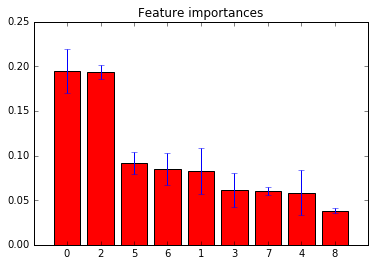

In [285]:

#Tropical,Arid (F) vs Temperate, Cold, Polar (G)
y_ = lb.inverse_transform(Y)
for l in range(0,len(y_)):
    if y_[l]=='A' or y_[l]=='B':
        y_[l] = 'F'
    else:
        y_[l] = 'G'
class_grouped(X,y_,fts)

Dummy Classifier
0.509601965602
Linear SVM Classification C-V:
[ 0.56097561  0.58536585  0.5         0.59259259  0.6125    ]
Accuracy: 0.57 (+/- 0.08)
Linear SVM Feature Importance:
Feature ranking:
1. feature 4 - 11A Front Rounded Vowels (3.399769)
2. feature 7 - 28A Case Syncretism (3.025597)
3. feature 1 - 6A Uvular Consonants (2.814604)
4. feature 2 - 7A Glottalized Consonants (2.551807)
5. feature 5 - 19A Presence of Uncommon Consonants (2.123934)
6. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (1.460799)
7. feature 8 - 29A Syncretism in Verbal Person/Number Marking (1.199711)
8. feature 6 - 8A Lateral Consonants (0.683350)
9. feature 3 - 4A Voicing in Plosives and Fricatives (0.672195)


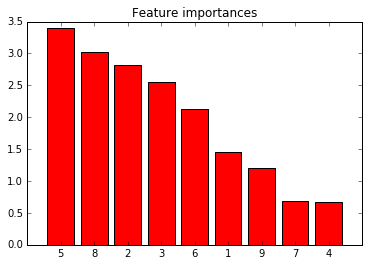


Random Forest Classification:
[ 0.54878049  0.65853659  0.53658537  0.56790123  0.7125    ]
Accuracy: 0.60 (+/- 0.14)
Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.166114)
2. feature 2 - 7A Glottalized Consonants (0.144471)
3. feature 6 - 8A Lateral Consonants (0.104024)
4. feature 1 - 6A Uvular Consonants (0.087274)
5. feature 4 - 11A Front Rounded Vowels (0.072889)
6. feature 5 - 19A Presence of Uncommon Consonants (0.070707)
7. feature 7 - 28A Case Syncretism (0.069405)
8. feature 3 - 4A Voicing in Plosives and Fricatives (0.051018)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.041774)


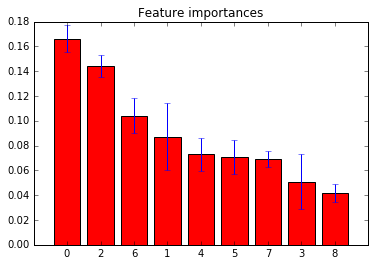


Extra Trees Classification:
[ 0.57317073  0.64634146  0.48780488  0.56790123  0.65      ]
Accuracy: 0.59 (+/- 0.12)
Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.182838)
2. feature 2 - 7A Glottalized Consonants (0.156729)
3. feature 1 - 6A Uvular Consonants (0.084697)
4. feature 6 - 8A Lateral Consonants (0.084240)
5. feature 4 - 11A Front Rounded Vowels (0.074823)
6. feature 3 - 4A Voicing in Plosives and Fricatives (0.074305)
7. feature 5 - 19A Presence of Uncommon Consonants (0.058673)
8. feature 7 - 28A Case Syncretism (0.048434)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.043880)


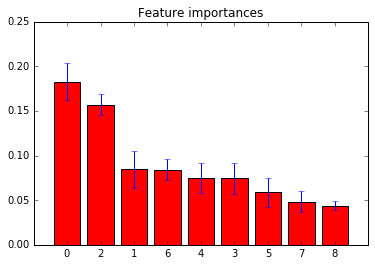

In [286]:
#Arid,Temperate(J) vs Tropical,Cold,Polar(K)
y_ = lb.inverse_transform(Y)
for l in range(0,len(y_)):
    if y_[l]=='B' or y_[l]=='C':
        y_[l] = 'J'
    else:
        y_[l] = 'K'

class_grouped(X,y_,fts)

Dummy Classifier
0.510555282555
Linear SVM Classification C-V:
[ 0.72289157  0.71604938  0.69135802  0.74074074  0.79012346]
Accuracy: 0.73 (+/- 0.07)
Linear SVM Feature Importance:
Feature ranking:
1. feature 5 - 19A Presence of Uncommon Consonants (3.410469)
2. feature 4 - 11A Front Rounded Vowels (3.032915)
3. feature 1 - 6A Uvular Consonants (2.646745)
4. feature 2 - 7A Glottalized Consonants (2.113842)
5. feature 3 - 4A Voicing in Plosives and Fricatives (1.860971)
6. feature 7 - 28A Case Syncretism (1.330580)
7. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.952815)
8. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.815614)
9. feature 6 - 8A Lateral Consonants (0.611319)


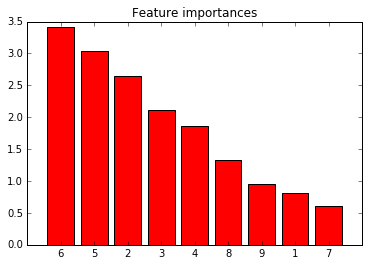


Random Forest Classification:
[ 0.6746988   0.79012346  0.64197531  0.66666667  0.72839506]
Accuracy: 0.70 (+/- 0.11)
Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.148671)
2. feature 1 - 6A Uvular Consonants (0.128073)
3. feature 2 - 7A Glottalized Consonants (0.103332)
4. feature 6 - 8A Lateral Consonants (0.084027)
5. feature 4 - 11A Front Rounded Vowels (0.083015)
6. feature 7 - 28A Case Syncretism (0.076039)
7. feature 3 - 4A Voicing in Plosives and Fricatives (0.067015)
8. feature 5 - 19A Presence of Uncommon Consonants (0.051104)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.021604)


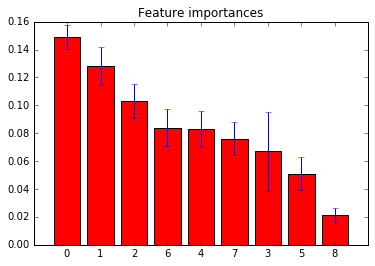


Extra Trees Classification:
[ 0.69879518  0.7654321   0.67901235  0.7037037   0.75308642]
Accuracy: 0.72 (+/- 0.07)
Feature ranking:
1. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.152446)
2. feature 1 - 6A Uvular Consonants (0.145581)
3. feature 2 - 7A Glottalized Consonants (0.111517)
4. feature 6 - 8A Lateral Consonants (0.087136)
5. feature 7 - 28A Case Syncretism (0.071204)
6. feature 5 - 19A Presence of Uncommon Consonants (0.069407)
7. feature 4 - 11A Front Rounded Vowels (0.061576)
8. feature 3 - 4A Voicing in Plosives and Fricatives (0.056330)
9. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.042058)


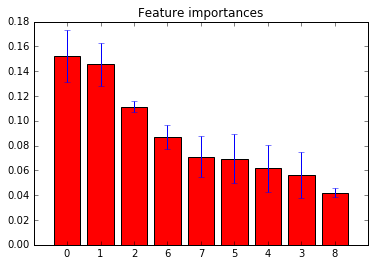

In [287]:
#Tropical(L) vs Temperate,Cold,Polar(M)
y_ = lb.inverse_transform(Y)
for l in range(0,len(y_)):
    if y_[l]=='A':
        y_[l] = 'L'
    else:
        y_[l] = 'M'
class_grouped(X,y_,fts)

Dummy Classifier
0.573157894737
Linear SVM Classification C-V:
[ 0.5483871   0.4516129   0.4         0.53333333  0.46666667]
Accuracy: 0.48 (+/- 0.11)
Linear SVM Feature Importance:
Feature ranking:
1. feature 2 - 7A Glottalized Consonants (4.326521)
2. feature 4 - 11A Front Rounded Vowels (2.910743)
3. feature 6 - 8A Lateral Consonants (2.604906)
4. feature 5 - 19A Presence of Uncommon Consonants (1.948667)
5. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (1.938311)
6. feature 1 - 6A Uvular Consonants (1.751695)
7. feature 8 - 29A Syncretism in Verbal Person/Number Marking (1.258885)
8. feature 7 - 28A Case Syncretism (1.033340)
9. feature 3 - 4A Voicing in Plosives and Fricatives (0.936620)


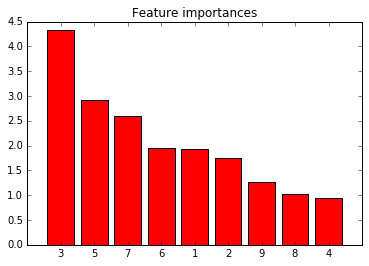


Random Forest Classification:
[ 0.67741935  0.61290323  0.63333333  0.56666667  0.63333333]
Accuracy: 0.62 (+/- 0.07)
Feature ranking:
1. feature 3 - 4A Voicing in Plosives and Fricatives (0.145721)
2. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.135373)
3. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.133824)
4. feature 7 - 28A Case Syncretism (0.129881)
5. feature 6 - 8A Lateral Consonants (0.127147)
6. feature 2 - 7A Glottalized Consonants (0.107644)
7. feature 1 - 6A Uvular Consonants (0.093616)
8. feature 5 - 19A Presence of Uncommon Consonants (0.078148)
9. feature 4 - 11A Front Rounded Vowels (0.048645)


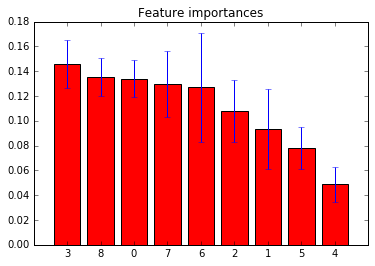


Extra Trees Classification:
[ 0.51612903  0.64516129  0.53333333  0.6         0.46666667]
Accuracy: 0.55 (+/- 0.13)
Feature ranking:
1. feature 3 - 4A Voicing in Plosives and Fricatives (0.150504)
2. feature 0 - 26A Prefixing vs. Suffixing in Inflectional Morphology (0.140023)
3. feature 7 - 28A Case Syncretism (0.127543)
4. feature 6 - 8A Lateral Consonants (0.124069)
5. feature 2 - 7A Glottalized Consonants (0.113819)
6. feature 8 - 29A Syncretism in Verbal Person/Number Marking (0.107560)
7. feature 5 - 19A Presence of Uncommon Consonants (0.101062)
8. feature 1 - 6A Uvular Consonants (0.083430)
9. feature 4 - 11A Front Rounded Vowels (0.051991)


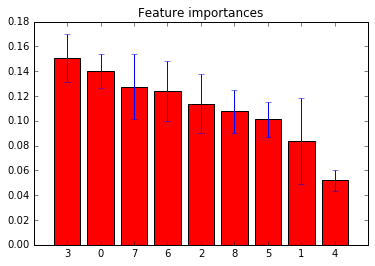

In [329]:
#Temperate(L) vs Tropical,Cold,Polar(M)
y_ = lb.inverse_transform(Y)
for l in range(0,len(y_)):
    if y_[l]=='C':
        y_[l] = 'N'
    else:
        y_[l] = 'O'
class_grouped(X,y_,fts)